In [59]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
import warnings
warnings.filterwarnings("ignore")

# 1. Data Collection

In [60]:
#load the data

df = pd.read_csv("D:\Kaggle\Walmart.csv")
df.head()

Store        Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0      1  05-02-2010    1643690.90             0        42.31       2.572   
1      1  12-02-2010    1641957.44             1        38.51       2.548   
2      1  19-02-2010    1611968.17             0        39.93       2.514   
3      1  26-02-2010    1409727.59             0        46.63       2.561   
4      1  05-03-2010    1554806.68             0        46.50       2.625   

          CPI  Unemployment  
0  211.096358         8.106  
1  211.242170         8.106  
2  211.289143         8.106  
3  211.319643         8.106  
4  211.350143         8.106

In [61]:
#check the data types
df.dtypes

Store             int64
Date             object
Weekly_Sales    float64
Holiday_Flag      int64
Temperature     float64
Fuel_Price      float64
CPI             float64
Unemployment    float64
dtype: object

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [63]:
#convert date to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

In [64]:
# Set 'Date' as index
df.set_index('Date', inplace=True)

In [65]:
#check the data types again
df.dtypes

Store             int64
Weekly_Sales    float64
Holiday_Flag      int64
Temperature     float64
Fuel_Price      float64
CPI             float64
Unemployment    float64
dtype: object

In [66]:
df.head(10)

Store  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
Date                                                                     
2010-02-05      1    1643690.90             0        42.31       2.572   
2010-02-12      1    1641957.44             1        38.51       2.548   
2010-02-19      1    1611968.17             0        39.93       2.514   
2010-02-26      1    1409727.59             0        46.63       2.561   
2010-03-05      1    1554806.68             0        46.50       2.625   
2010-03-12      1    1439541.59             0        57.79       2.667   
2010-03-19      1    1472515.79             0        54.58       2.720   
2010-03-26      1    1404429.92             0        51.45       2.732   
2010-04-02      1    1594968.28             0        62.27       2.719   
2010-04-09      1    1545418.53             0        65.86       2.770   

                   CPI  Unemployment  
Date                                  
2010-02-05  211.096358         8.106  
2010-02-12  211.242170         8.106  
2010-02-19  211.289143         8.106  
2010-02-26  211.319643         8.106  
2010-03-05  211.350143         8.106  
2010-03-12  211.380643         8.106  
2010-03-19  211.215635         8.106  
2010-03-26  211.018042         8.106  
2010-04-02  210.820450         7.808  
2010-04-09  210.622857         7.808

In [67]:
#sort data by date for each store
df_sorted = df.sort_values(by=['Store', 'Date']).reset_index(drop=True)

In [68]:
df.head(10)

Store  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
Date                                                                     
2010-02-05      1    1643690.90             0        42.31       2.572   
2010-02-12      1    1641957.44             1        38.51       2.548   
2010-02-19      1    1611968.17             0        39.93       2.514   
2010-02-26      1    1409727.59             0        46.63       2.561   
2010-03-05      1    1554806.68             0        46.50       2.625   
2010-03-12      1    1439541.59             0        57.79       2.667   
2010-03-19      1    1472515.79             0        54.58       2.720   
2010-03-26      1    1404429.92             0        51.45       2.732   
2010-04-02      1    1594968.28             0        62.27       2.719   
2010-04-09      1    1545418.53             0        65.86       2.770   

                   CPI  Unemployment  
Date                                  
2010-02-05  211.096358         8.106  
2010-02-12  211.242170         8.106  
2010-02-19  211.289143         8.106  
2010-02-26  211.319643         8.106  
2010-03-05  211.350143         8.106  
2010-03-12  211.380643         8.106  
2010-03-19  211.215635         8.106  
2010-03-26  211.018042         8.106  
2010-04-02  210.820450         7.808  
2010-04-09  210.622857         7.808

# 2. Data cleaning

In [69]:
#Handle missing values
df.isnull().sum()

Store           0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

In [70]:
# Aggregate weekly sales per store
weekly_df = df.groupby('Store').resample('W').agg({
    'Weekly_Sales': 'sum',
    'Holiday_Flag': 'max',         
    'Temperature': 'mean',
    'Fuel_Price': 'mean',
    'CPI': 'mean',
    'Unemployment': 'mean'
}).reset_index()

In [71]:
weekly_df.head()

Store       Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0      1 2010-02-07    1643690.90             0        42.31       2.572   
1      1 2010-02-14    1641957.44             1        38.51       2.548   
2      1 2010-02-21    1611968.17             0        39.93       2.514   
3      1 2010-02-28    1409727.59             0        46.63       2.561   
4      1 2010-03-07    1554806.68             0        46.50       2.625   

          CPI  Unemployment  
0  211.096358         8.106  
1  211.242170         8.106  
2  211.289143         8.106  
3  211.319643         8.106  
4  211.350143         8.106

In [72]:
#inspecting weekly trends for a particular store
weekly_df[weekly_df['Store'] == 6].head(10)

Store       Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
715      6 2010-02-07    1652635.10             0        40.43       2.572   
716      6 2010-02-14    1606283.86             1        40.57       2.548   
717      6 2010-02-21    1567138.07             0        43.58       2.514   
718      6 2010-02-28    1432953.21             0        47.10       2.561   
719      6 2010-03-07    1601348.82             0        49.63       2.625   
720      6 2010-03-14    1558621.36             0        58.82       2.667   
721      6 2010-03-21    1693058.91             0        56.55       2.720   
722      6 2010-03-28    1472033.38             0        53.74       2.732   
723      6 2010-04-04    1770333.90             0        64.94       2.719   
724      6 2010-04-11    1667181.82             0        66.15       2.770   

            CPI  Unemployment  
715  212.622352         7.259  
716  212.770042         7.259  
717  212.816155         7.259  
718  212.845337         7.259  
719  212.874519         7.259  
720  212.903702         7.259  
721  212.735194         7.259  
722  212.533737         7.259  
723  212.332280         7.092  
724  212.130824         7.092

# 3. Exploratory Data Analysis 

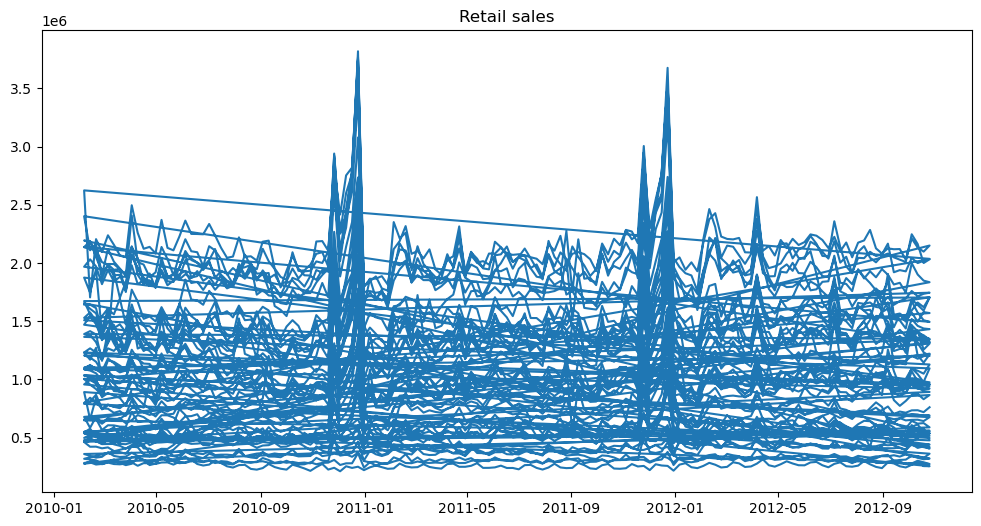

In [73]:
#plot the data

plt.figure(figsize=(12,6))
plt.plot(df['Weekly_Sales'])
plt.title("Retail sales")
plt.show()

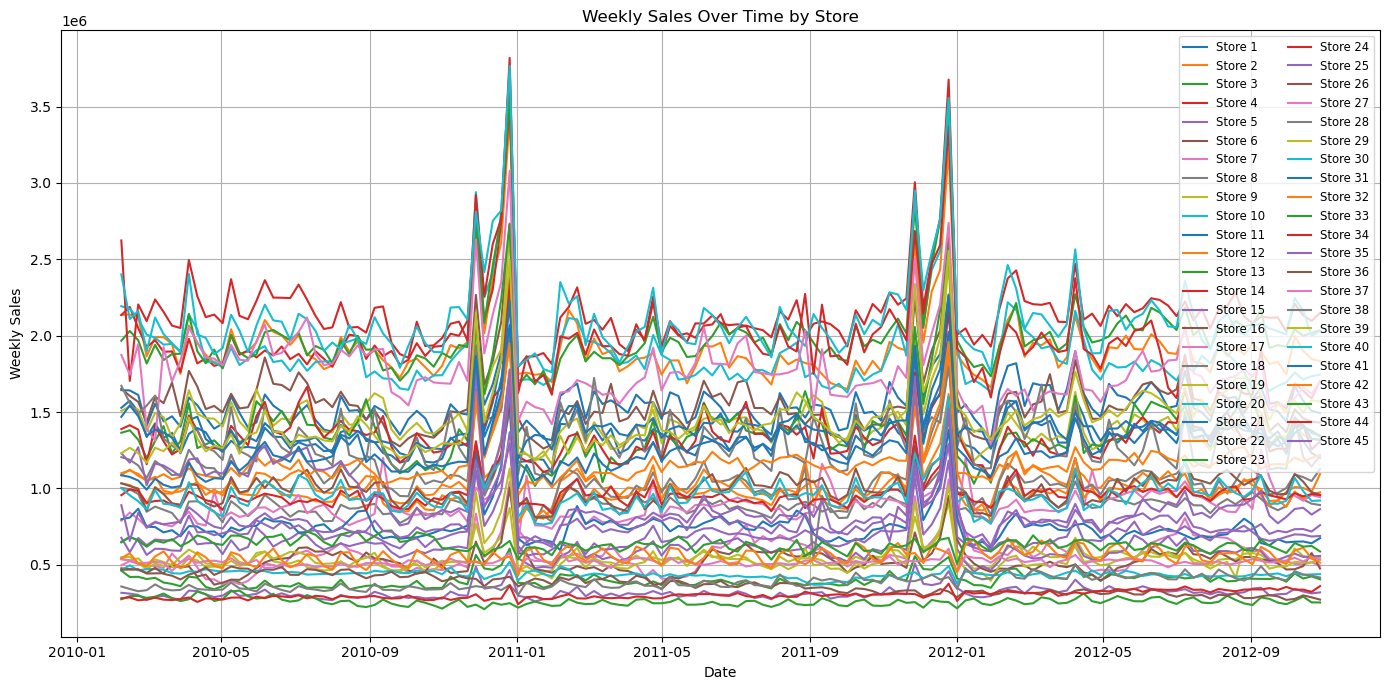

In [74]:
#Line plot of weekly sales over time (store-wise)

plt.figure(figsize=(14, 7))

# Loop through each store and plot its weekly sales
for store_id in weekly_df['Store'].unique():
    store_data = weekly_df[weekly_df['Store'] == store_id]
    plt.plot(store_data['Date'], store_data['Weekly_Sales'], label=f'Store {store_id}', linewidth=1.5)

plt.title('Weekly Sales Over Time by Store')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend(loc='upper right', ncol=2, fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

In [75]:
# Prepare data
holiday_data = weekly_df.copy()
holiday_data['Date'] = pd.to_datetime(holiday_data['Date'])
holiday_data = holiday_data.sort_values('Date')

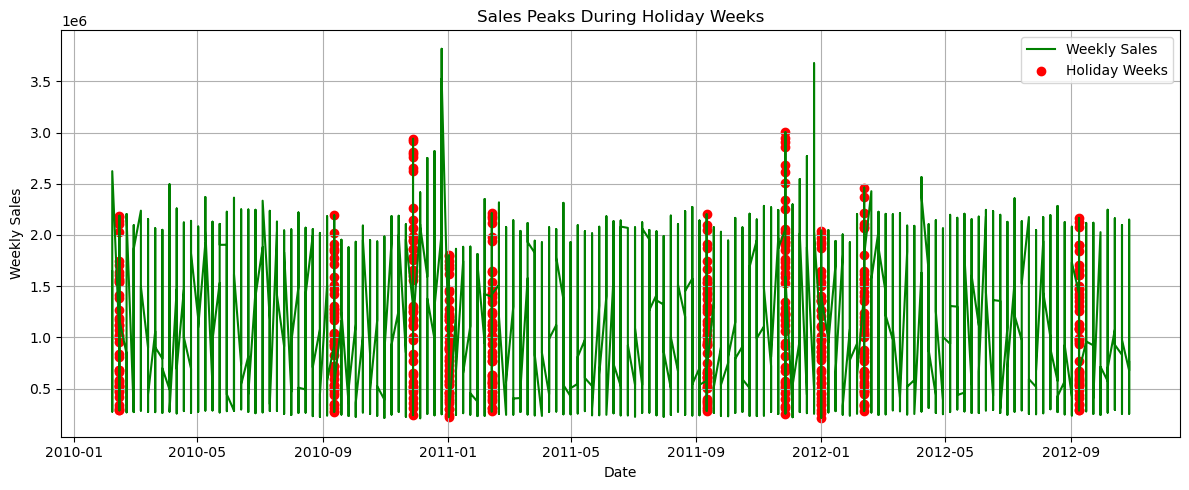

In [76]:
# Plot weekly sales
plt.figure(figsize=(12,5))
plt.plot(holiday_data['Date'], holiday_data['Weekly_Sales'], label='Weekly Sales', color='green')

# Highlight holiday weeks
holiday_weeks = holiday_data[holiday_data['Holiday_Flag'] == 1]
plt.scatter(holiday_weeks['Date'], holiday_weeks['Weekly_Sales'], color='red', label='Holiday Weeks')

# Final touches
plt.title("Sales Peaks During Holiday Weeks")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

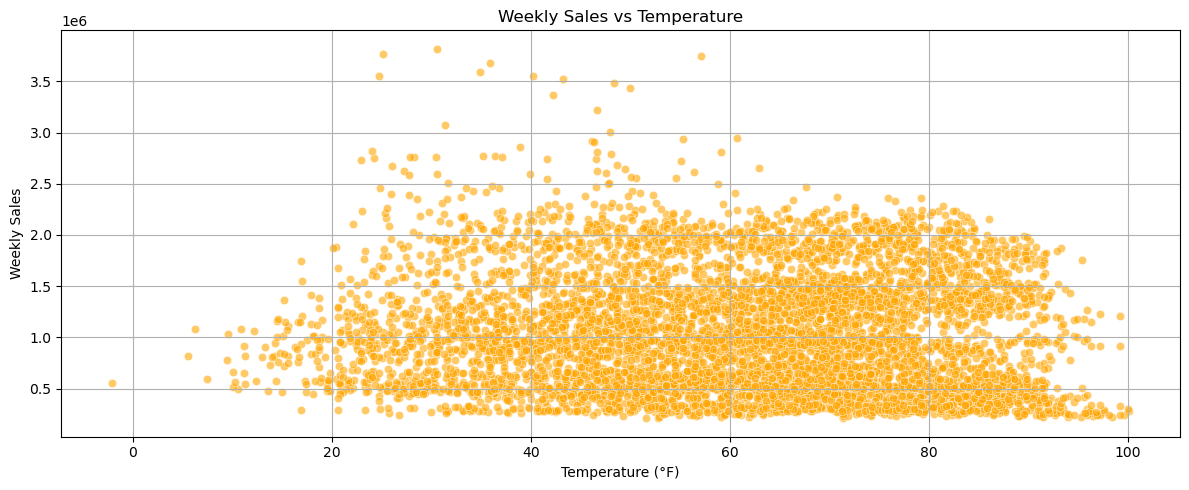

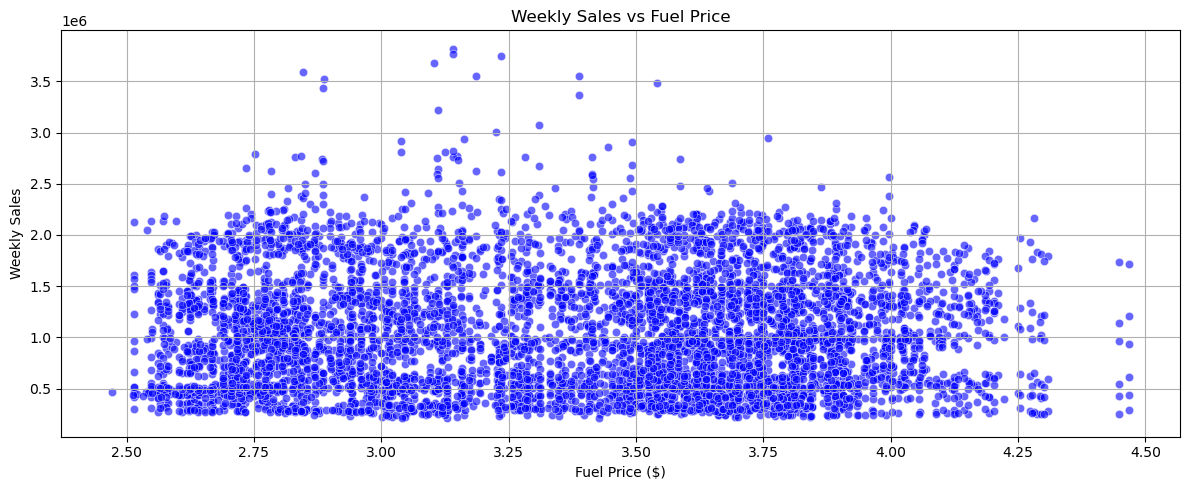

In [77]:
# Scatter plot: Temperature vs Weekly Sales
plt.figure(figsize=(12,5))
sns.scatterplot(data=weekly_df, x='Temperature', y='Weekly_Sales', alpha=0.6, color='orange')
plt.title("Weekly Sales vs Temperature")
plt.xlabel("Temperature (°F)")
plt.ylabel("Weekly Sales")
plt.grid(True)
plt.tight_layout()
plt.show()

# Scatter plot: Fuel Price vs Weekly Sales
plt.figure(figsize=(12,5))
sns.scatterplot(data=weekly_df, x='Fuel_Price', y='Weekly_Sales', alpha=0.6, color='blue')
plt.title("Weekly Sales vs Fuel Price")
plt.xlabel("Fuel Price ($)")
plt.ylabel("Weekly Sales")
plt.grid(True)
plt.tight_layout()
plt.show()

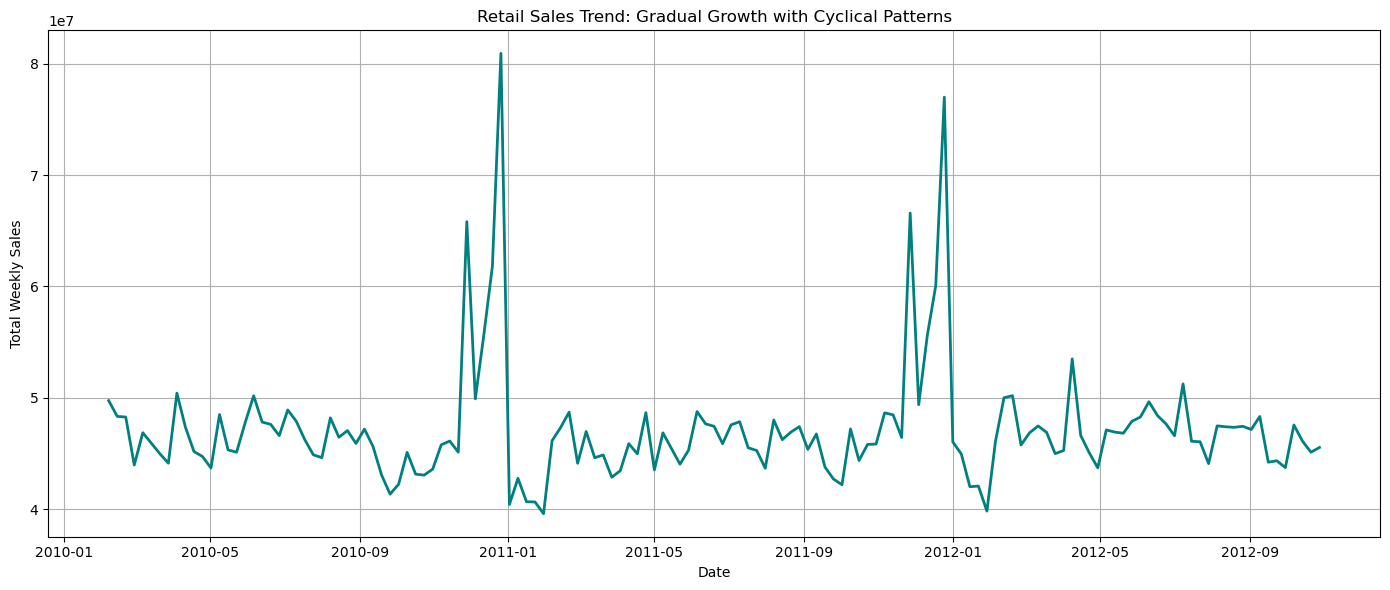

In [78]:
# Prepare data
trend_data = weekly_df.copy()
trend_data['Date'] = pd.to_datetime(trend_data['Date'])
trend_data = trend_data.sort_values('Date')

# Aggregate weekly sales across all stores
total_sales = trend_data.groupby('Date')['Weekly_Sales'].sum().reset_index()

# Plot
plt.figure(figsize=(14,6))
plt.plot(total_sales['Date'], total_sales['Weekly_Sales'], color='teal', linewidth=2)
plt.title("Retail Sales Trend: Gradual Growth with Cyclical Patterns")
plt.xlabel("Date")
plt.ylabel("Total Weekly Sales")
plt.grid(True)
plt.tight_layout()
plt.show()

In [79]:
#Performing ADF (Augmented Dickey-Fuller Test) to test stationarity.

# Create empty list to store results
results = []

# Loop through each store
for store in weekly_df['Store'].unique():
    sales = weekly_df[weekly_df['Store'] == store]['Weekly_Sales'].dropna()
    pval = adfuller(sales)[1]
    results.append([store, round(pval, 4), 'Stationary' if pval <= 0.05 else 'Not Stationary'])

# Convert to DataFrame
adf_results = pd.DataFrame(results, columns=['Store', 'p-value', 'Stationarity'])
print(adf_results)

    Store  p-value    Stationarity
0       1   0.0000      Stationary
1       2   0.0040      Stationary
2       3   0.0384      Stationary
3       4   0.0478      Stationary
4       5   0.0004      Stationary
5       6   0.0000      Stationary
6       7   0.0002      Stationary
7       8   0.0000      Stationary
8       9   0.0000      Stationary
9      10   0.0000      Stationary
10     11   0.0033      Stationary
11     12   0.0000      Stationary
12     13   0.0000      Stationary
13     14   0.0679  Not Stationary
14     15   0.0000      Stationary
15     16   0.0002      Stationary
16     17   0.0000      Stationary
17     18   0.0060      Stationary
18     19   0.0000      Stationary
19     20   0.0000      Stationary
20     21   0.0000      Stationary
21     22   0.0000      Stationary
22     23   0.0000      Stationary
23     24   0.0000      Stationary
24     25   0.0000      Stationary
25     26   0.0000      Stationary
26     27   0.0000      Stationary
27     28   0.0397  

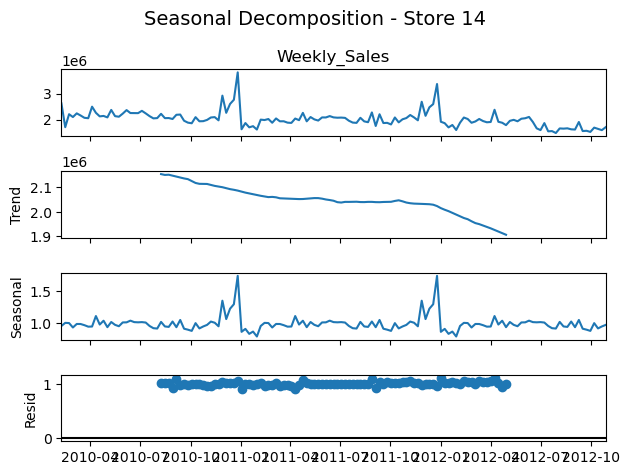

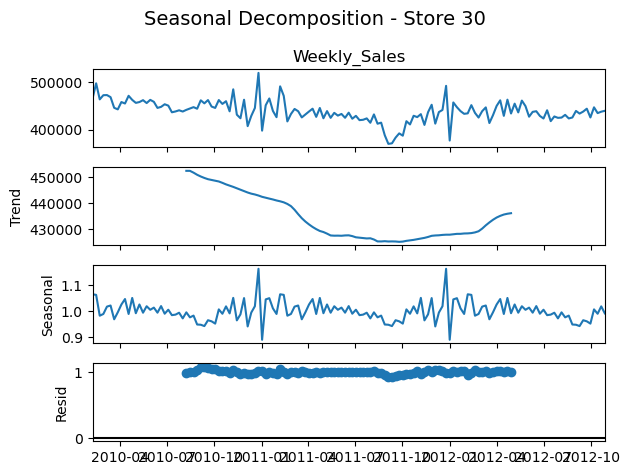

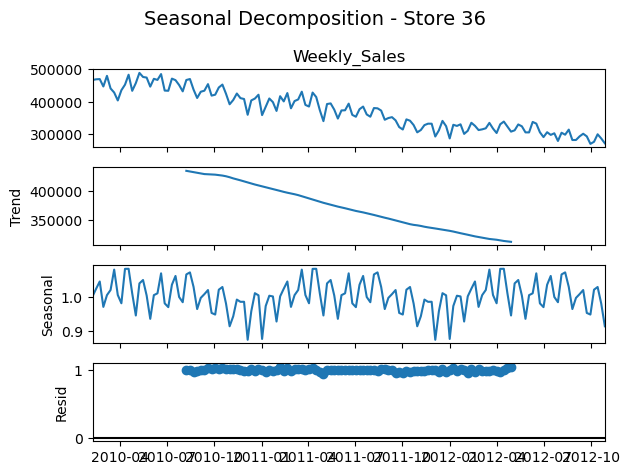

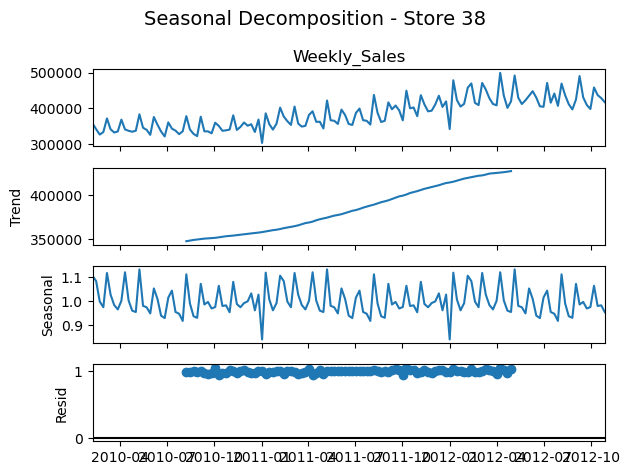

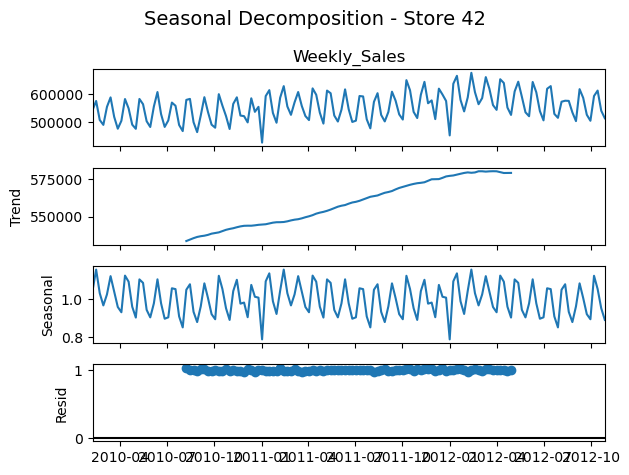

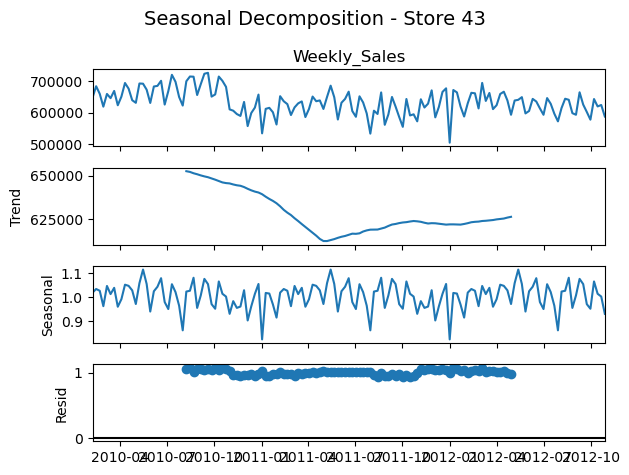

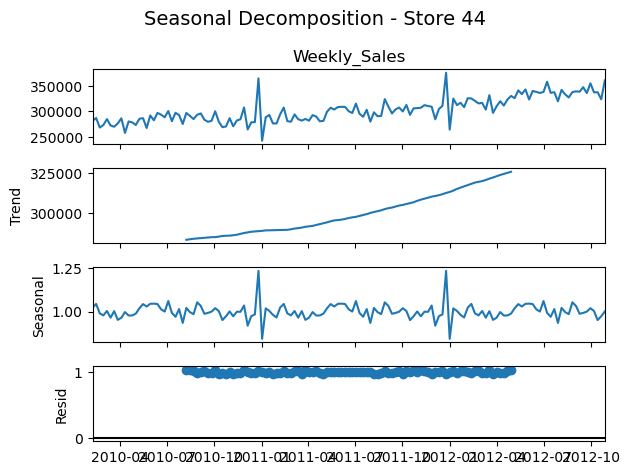

In [80]:
for store_id in [14, 30, 36, 38, 42, 43, 44]:
    store_data = weekly_df[weekly_df['Store'] == store_id].set_index('Date')
    sales = store_data['Weekly_Sales']
    
    if len(sales) < 60:
        continue
    
    decomposition = sm.tsa.seasonal_decompose(sales, model='multiplicative', period=52)
    decomposition.plot()
    plt.suptitle(f'Seasonal Decomposition - Store {store_id}', fontsize=14)
    plt.tight_layout()
    plt.show()

In [81]:
# List of non-stationary store IDs
non_stationary_stores = [14, 30, 36, 38, 42, 43, 44]

# Store results
diff_results = []

for store_id in non_stationary_stores:
    # Extract weekly sales for the store
    sales = weekly_df[weekly_df['Store'] == store_id]['Weekly_Sales'].dropna()
    
    # Apply first-order differencing
    sales_diff = sales.diff().dropna()
    
    # Run ADF test again
    pval = adfuller(sales_diff)[1]
    
    # Save result
    diff_results.append([store_id, round(pval, 4), 'Stationary' if pval <= 0.05 else 'Still Not Stationary'])

# Display results
pd.DataFrame(diff_results, columns=['Store', 'p-value after differencing', 'Stationarity'])

Store  p-value after differencing Stationarity
0     14                      0.0000   Stationary
1     30                      0.0000   Stationary
2     36                      0.0008   Stationary
3     38                      0.0001   Stationary
4     42                      0.0010   Stationary
5     43                      0.0028   Stationary
6     44                      0.0000   Stationary

In [82]:
#Correlation between temperature/fuel price and sales.
# Select relevant columns
corr_df = weekly_df[['Weekly_Sales', 'Temperature', 'Fuel_Price']]

# Compute correlation matrix
correlation_matrix = corr_df.corr()

# Display
print(correlation_matrix)

              Weekly_Sales  Temperature  Fuel_Price
Weekly_Sales      1.000000    -0.063810    0.009464
Temperature      -0.063810     1.000000    0.144982
Fuel_Price        0.009464     0.144982    1.000000


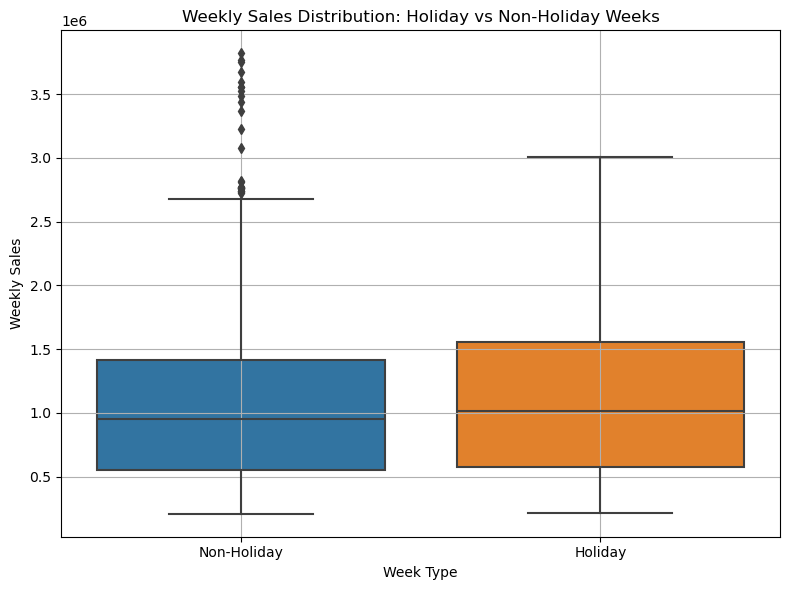

In [83]:
#Boxplot of sales during holiday vs non-holiday weeks.
plt.figure(figsize=(8, 6))
sns.boxplot(x='Holiday_Flag', y='Weekly_Sales', data=weekly_df)
plt.xticks([0, 1], ['Non-Holiday', 'Holiday'])
plt.title('Weekly Sales Distribution: Holiday vs Non-Holiday Weeks')
plt.xlabel('Week Type')
plt.ylabel('Weekly Sales')
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Model Selection and Training

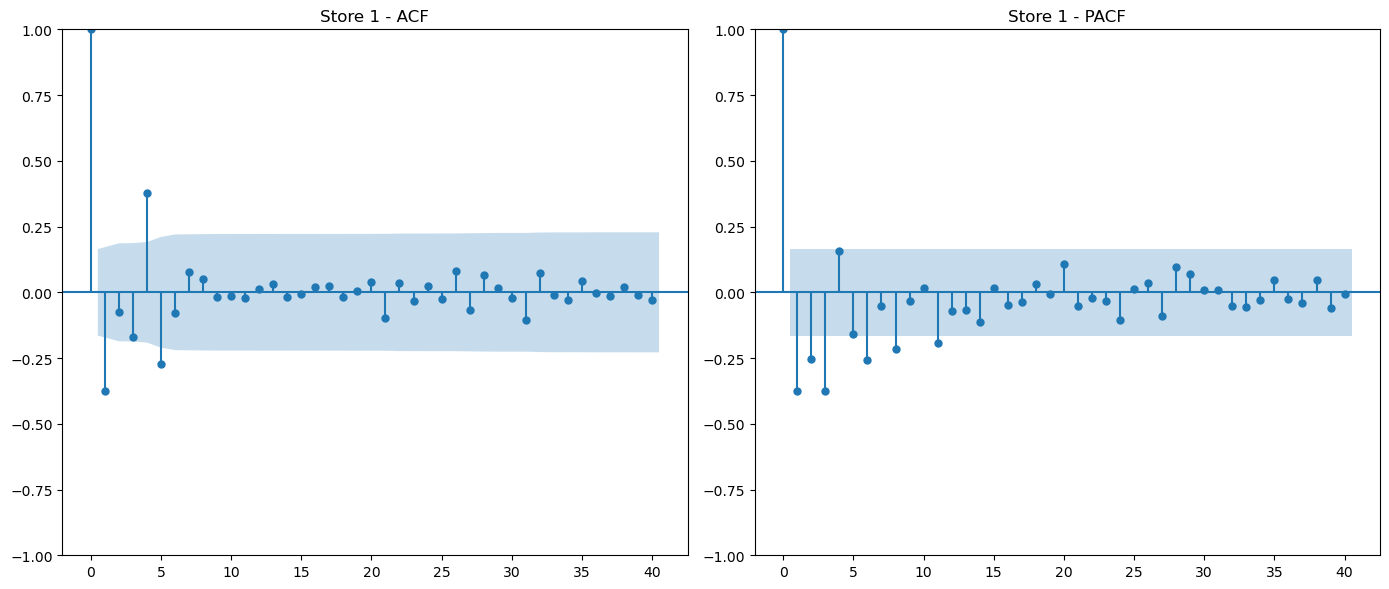

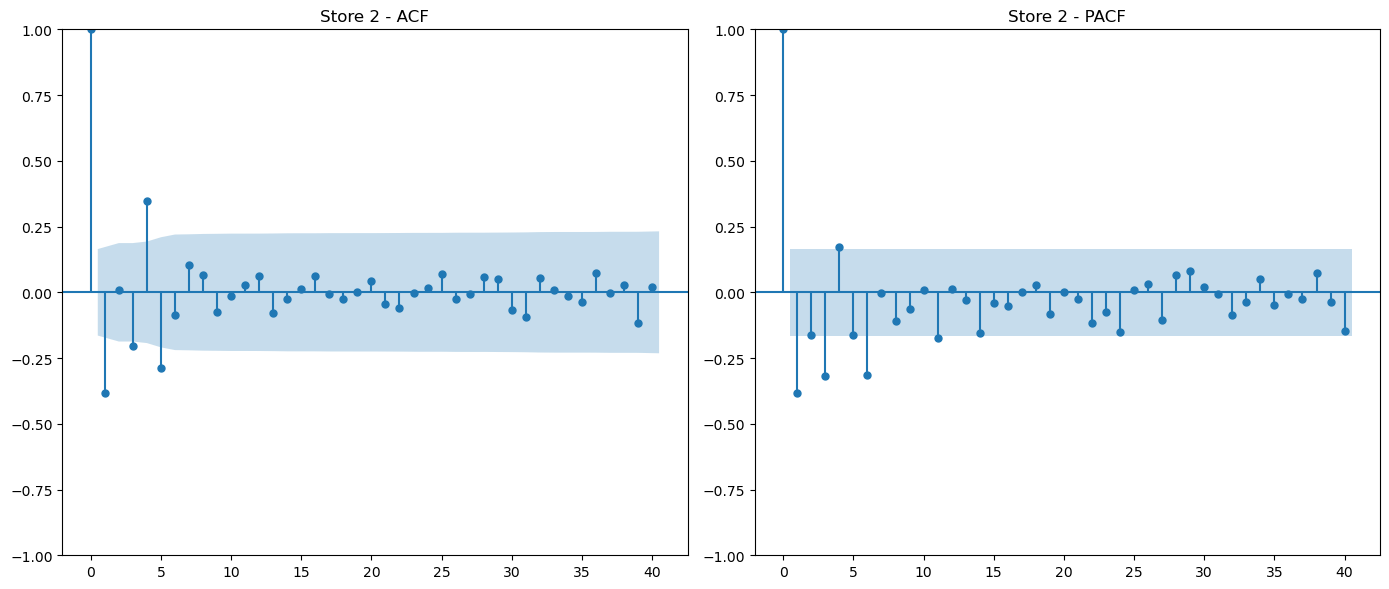

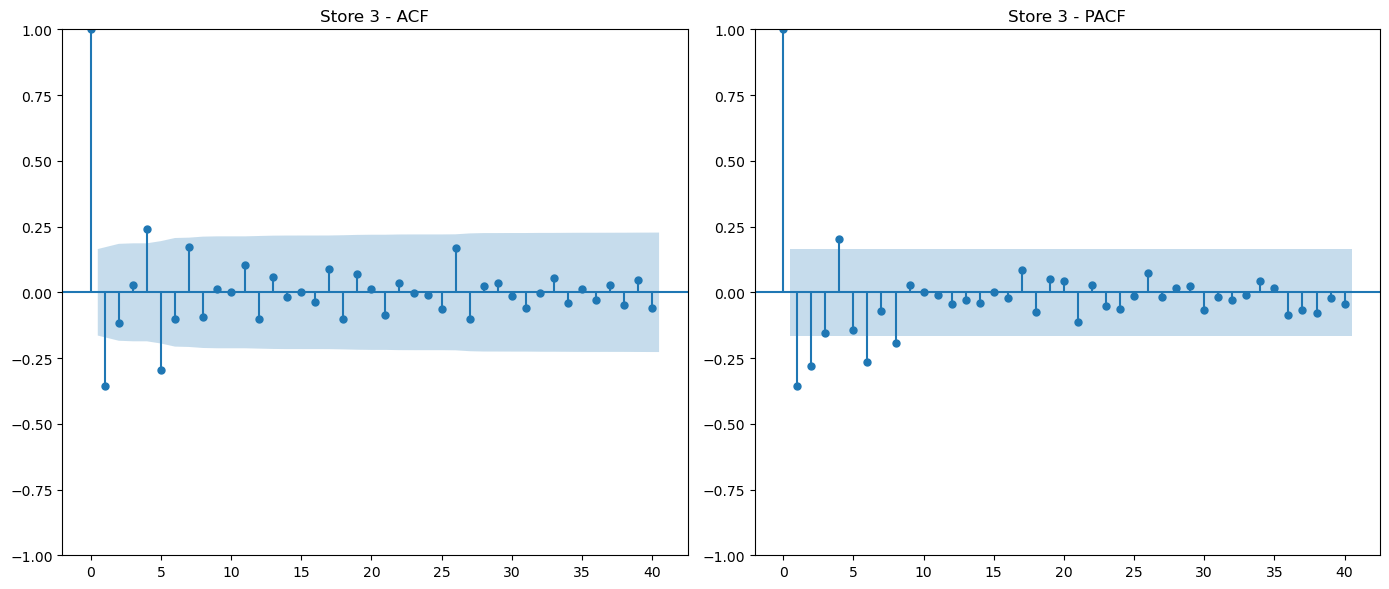

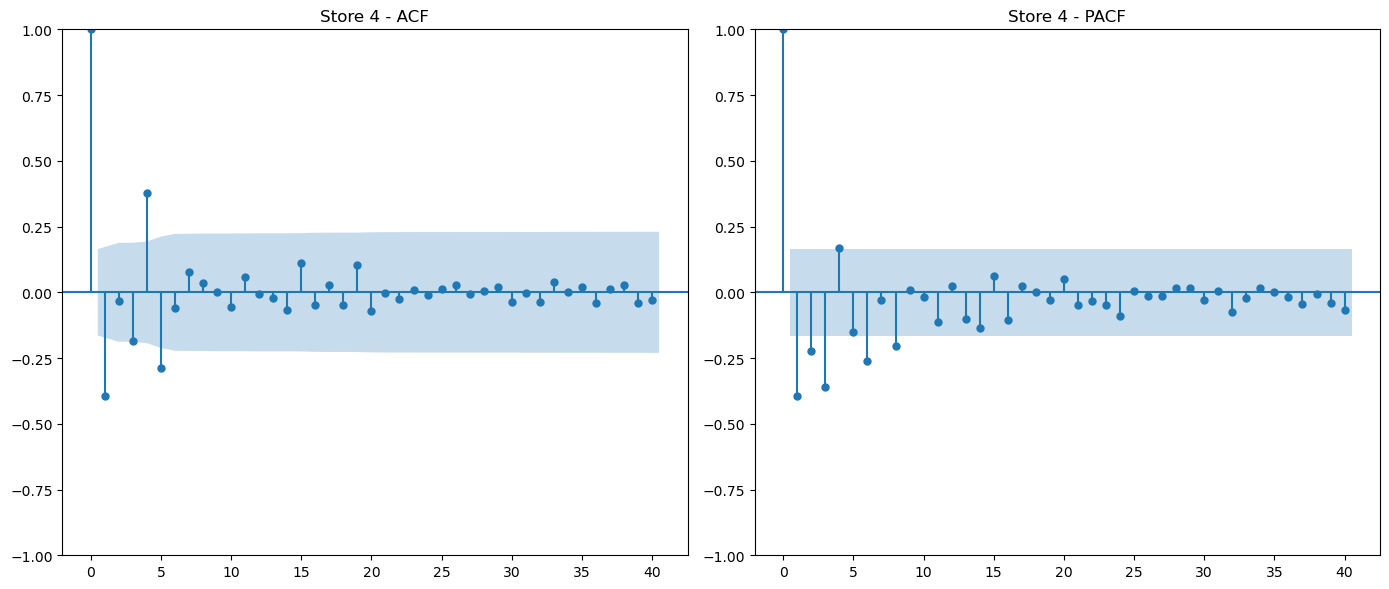

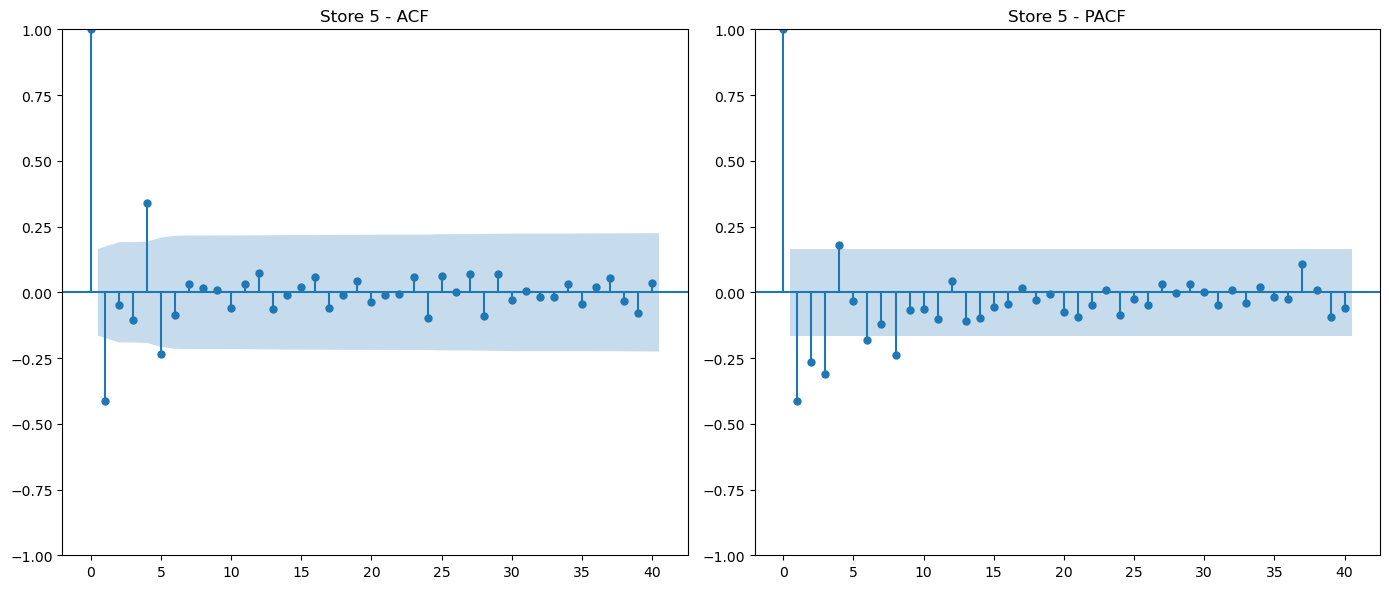

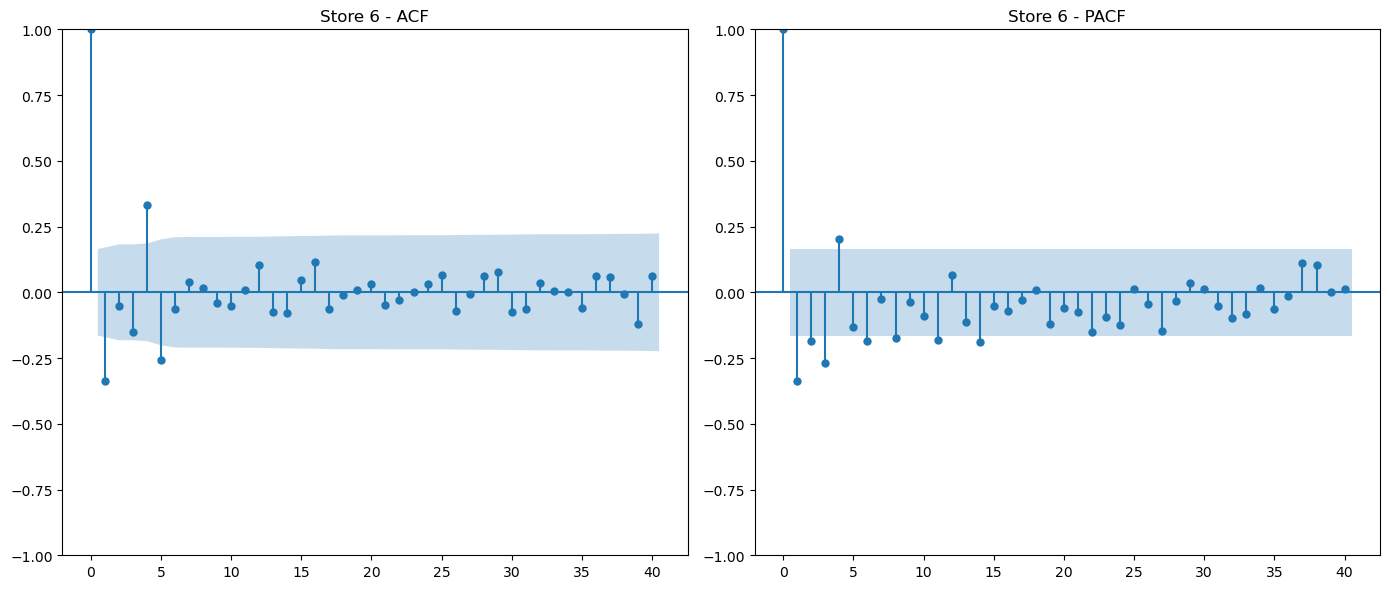

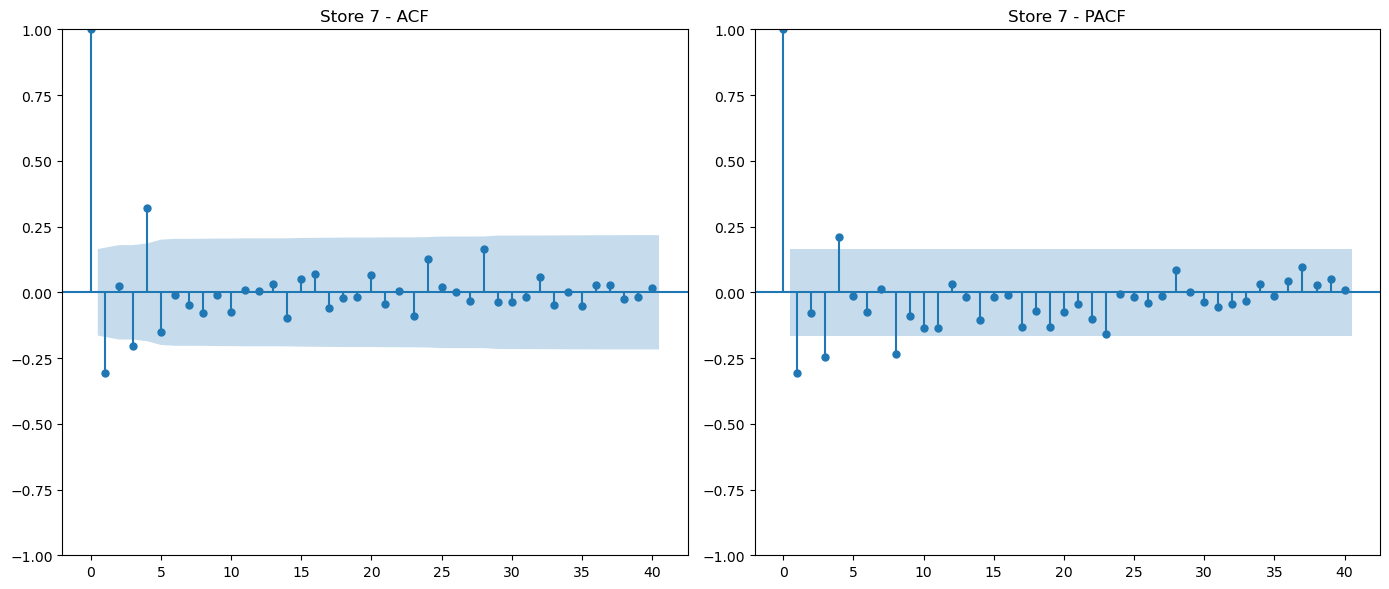

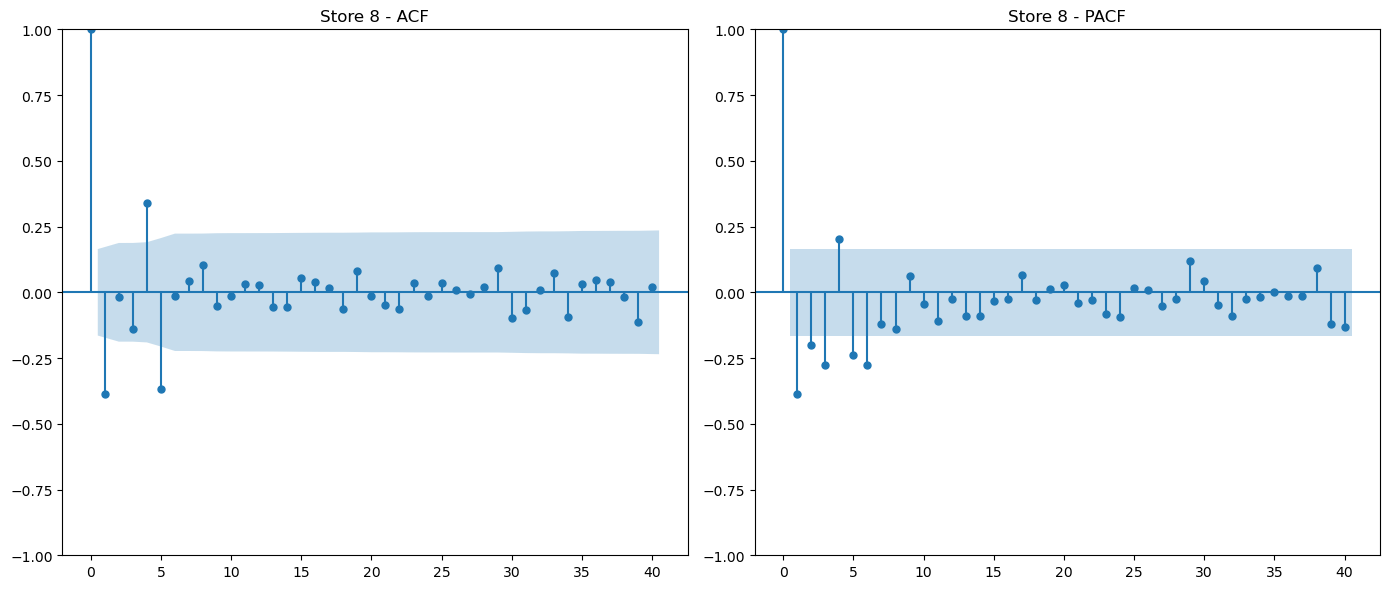

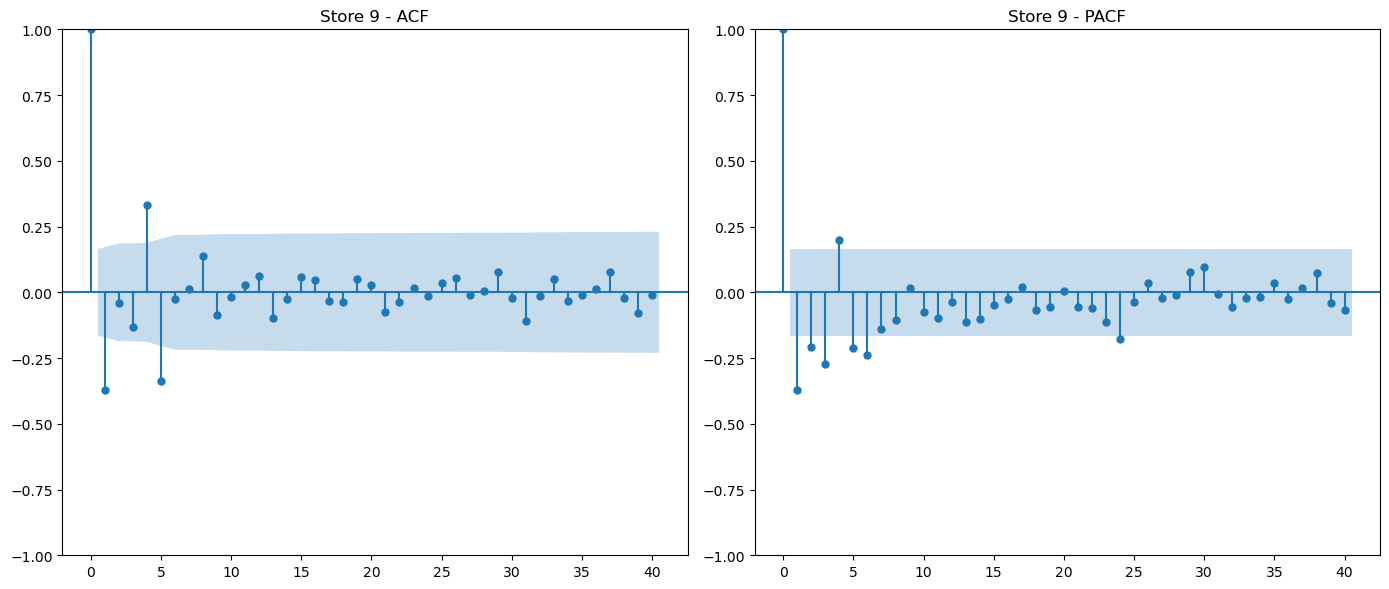

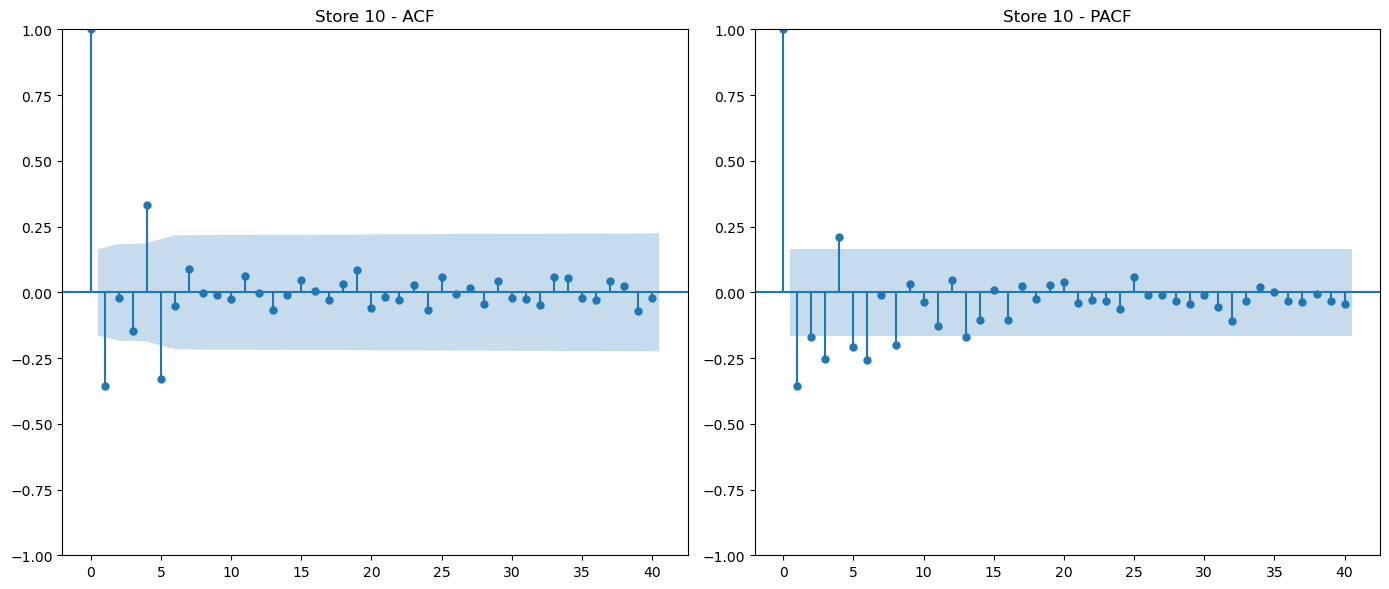

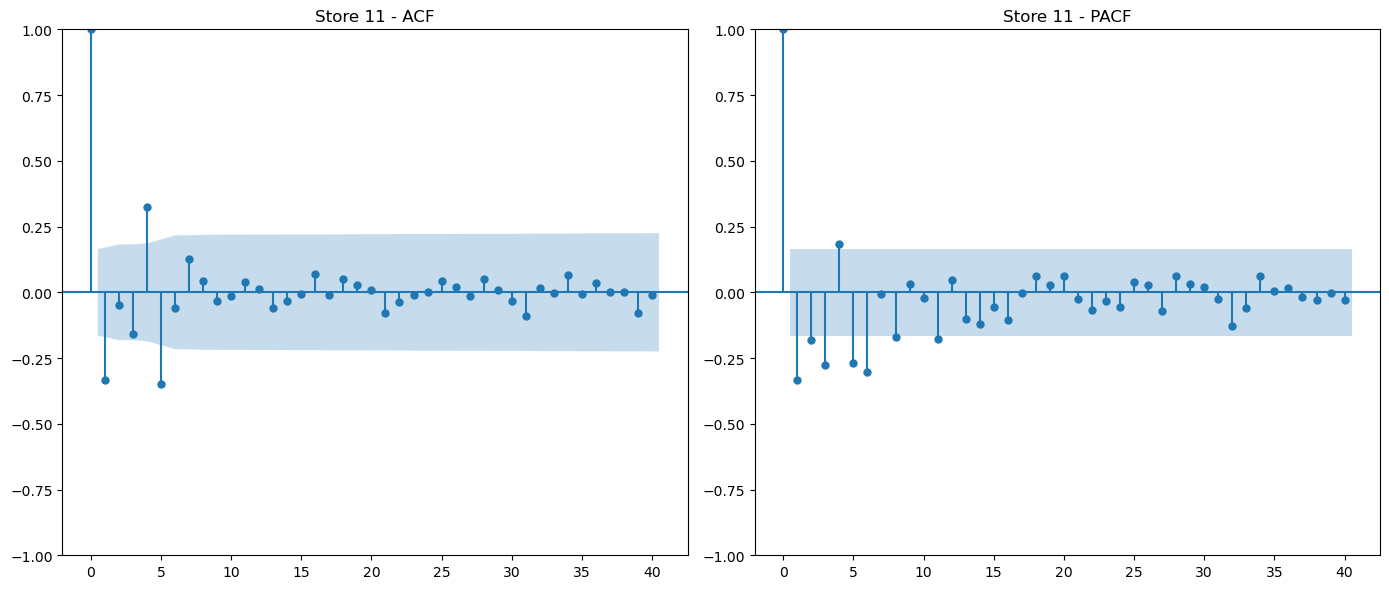

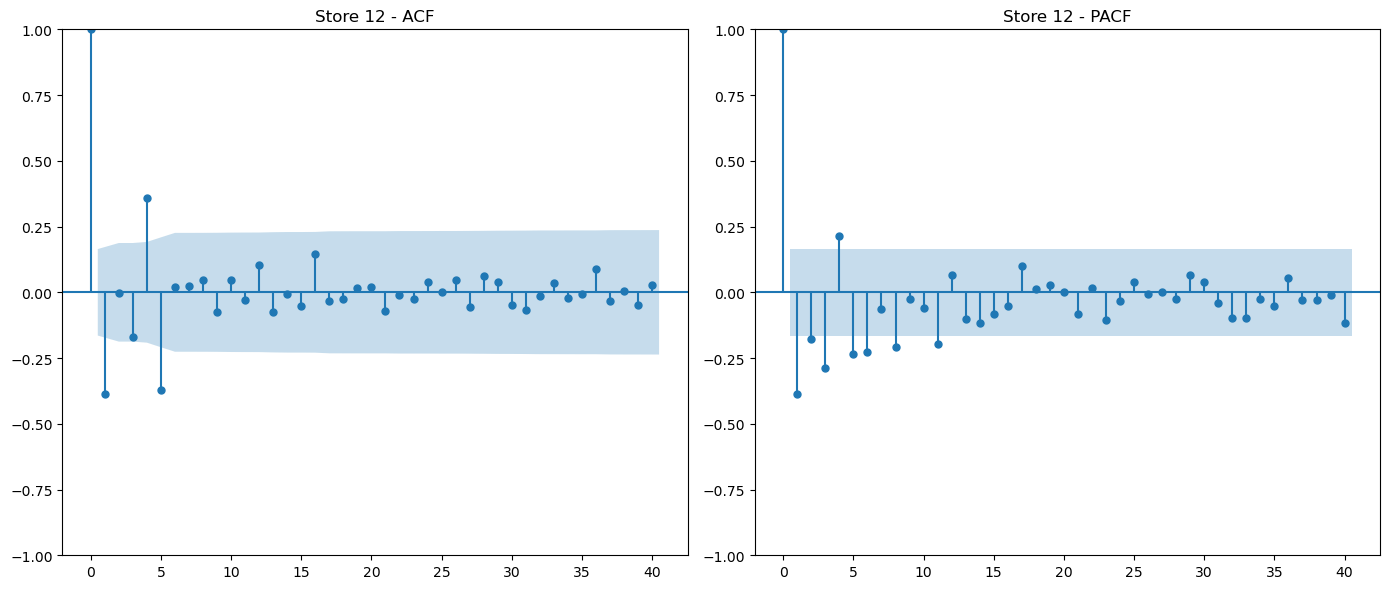

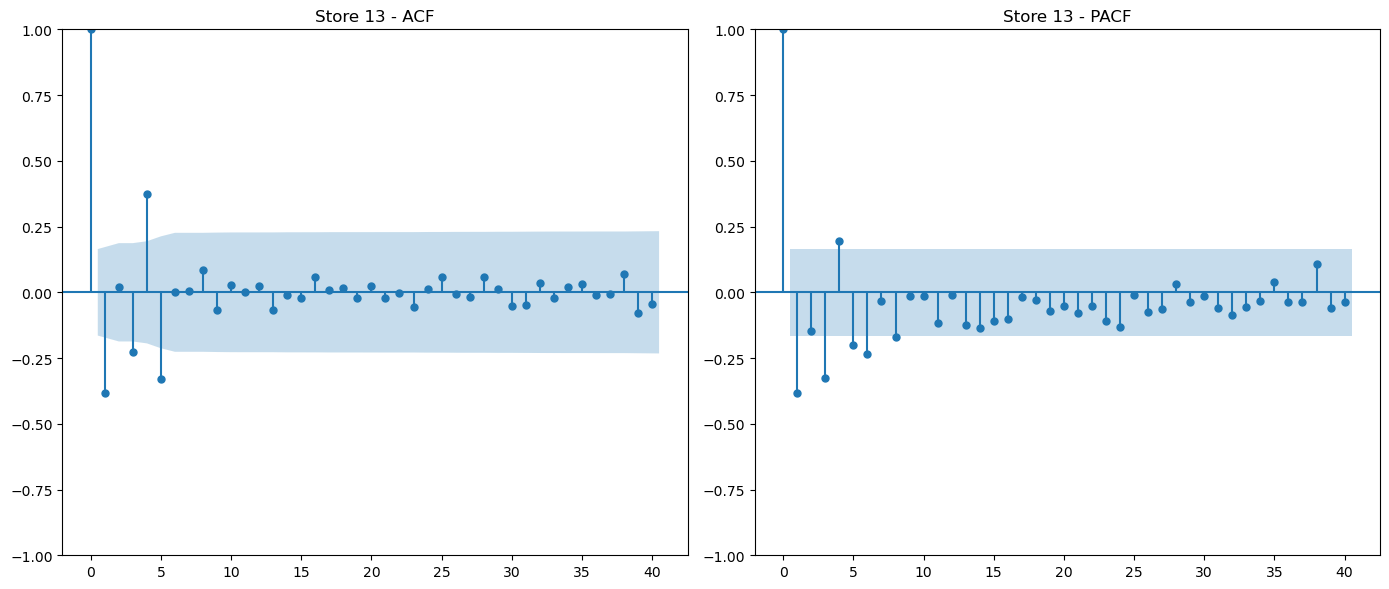

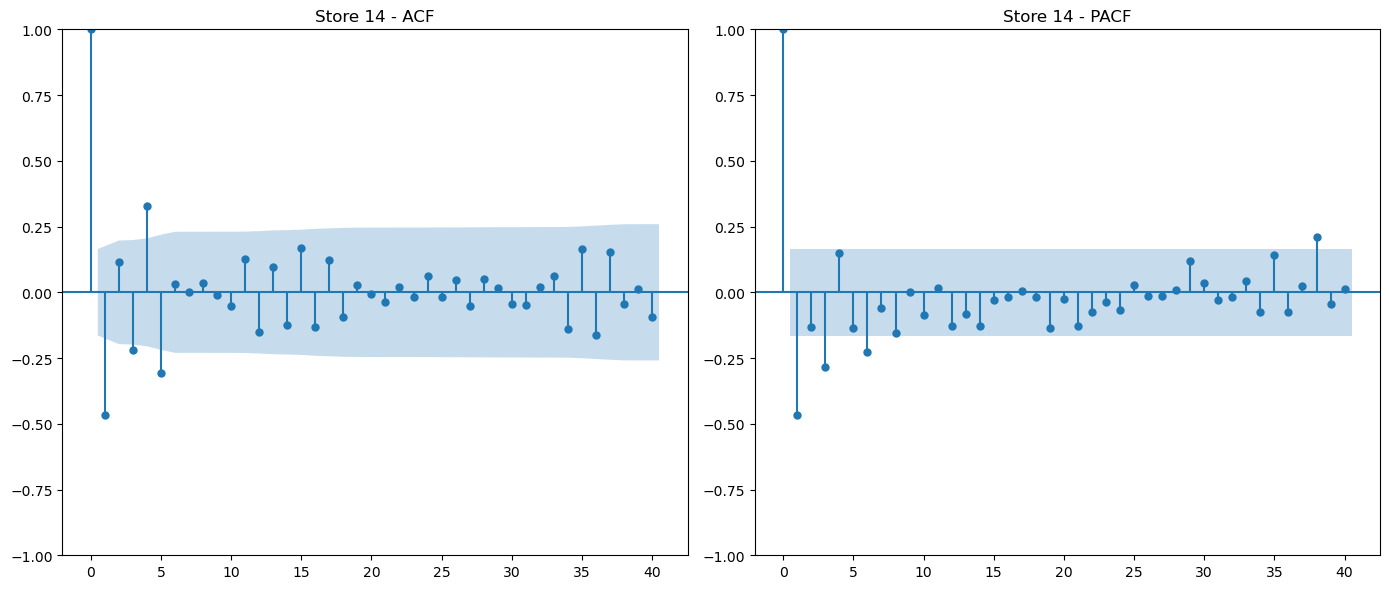

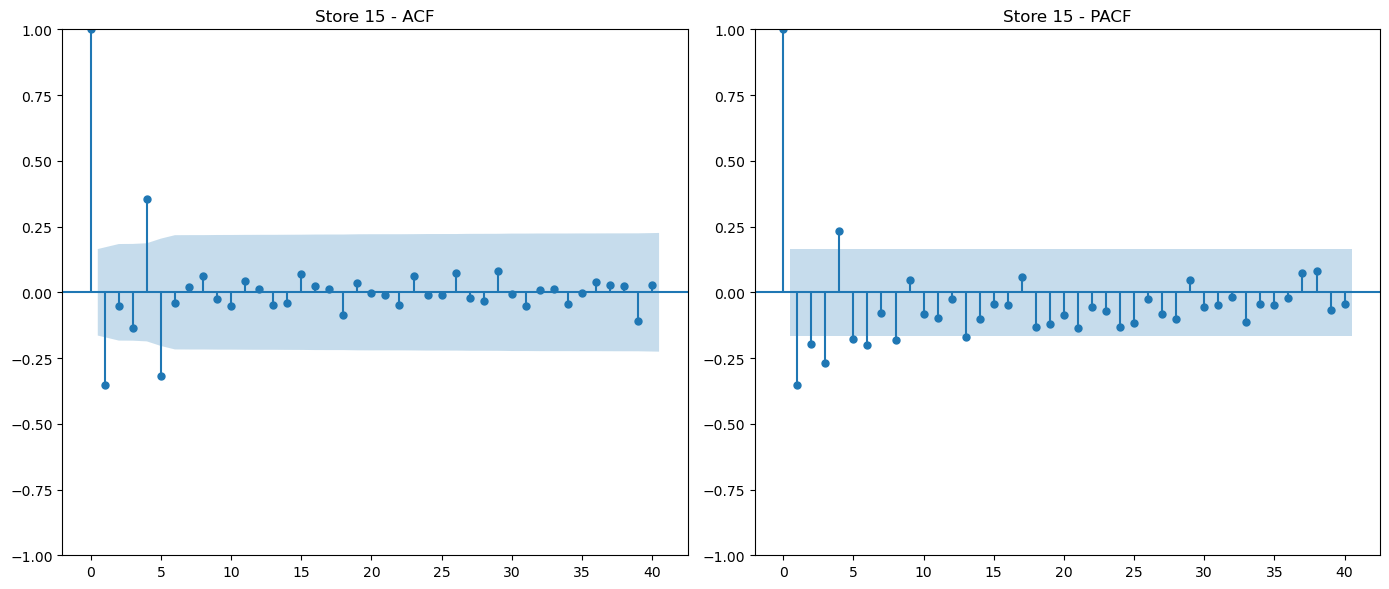

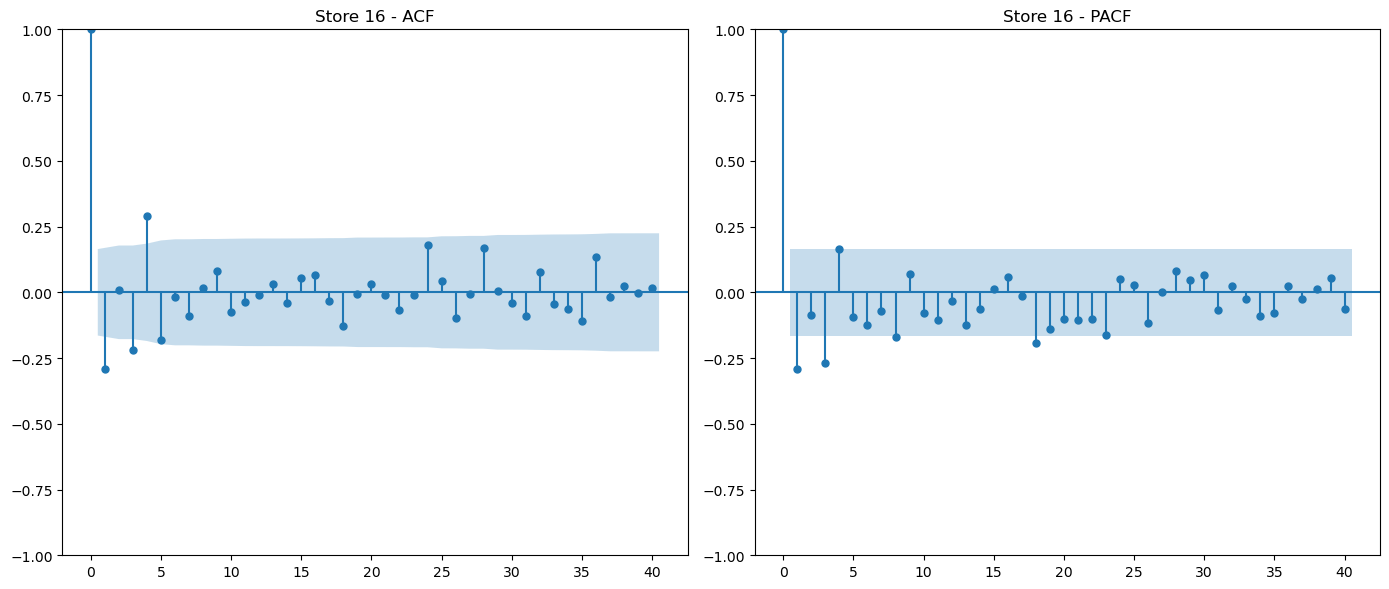

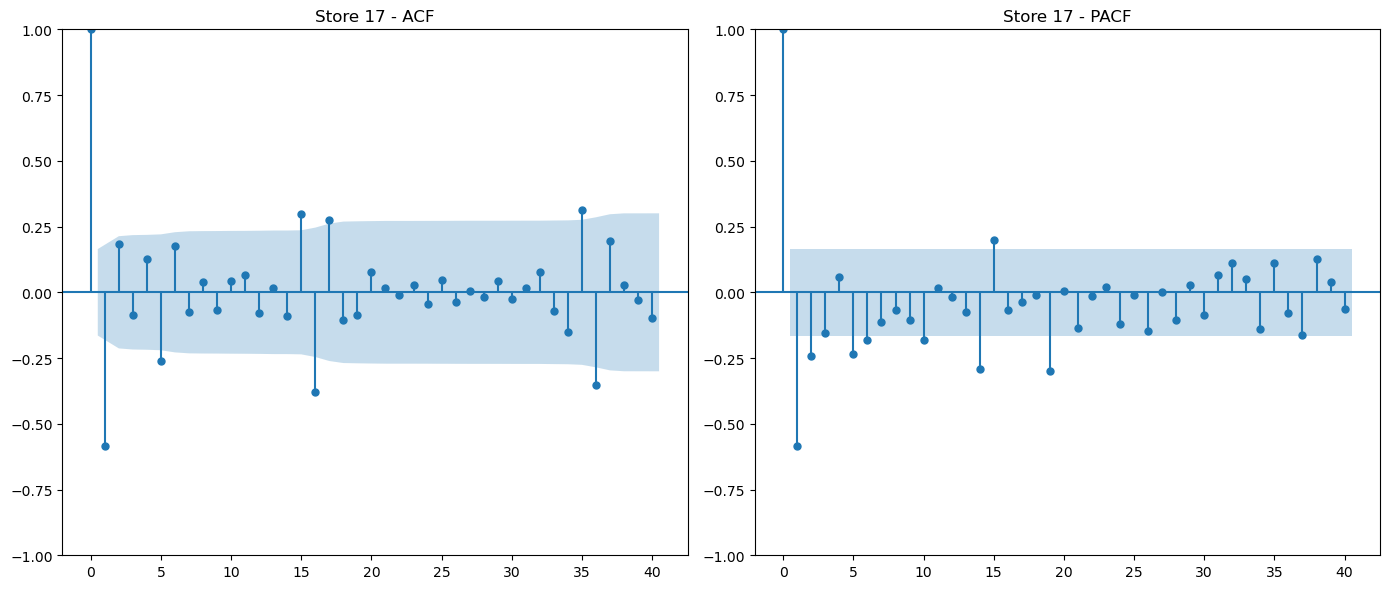

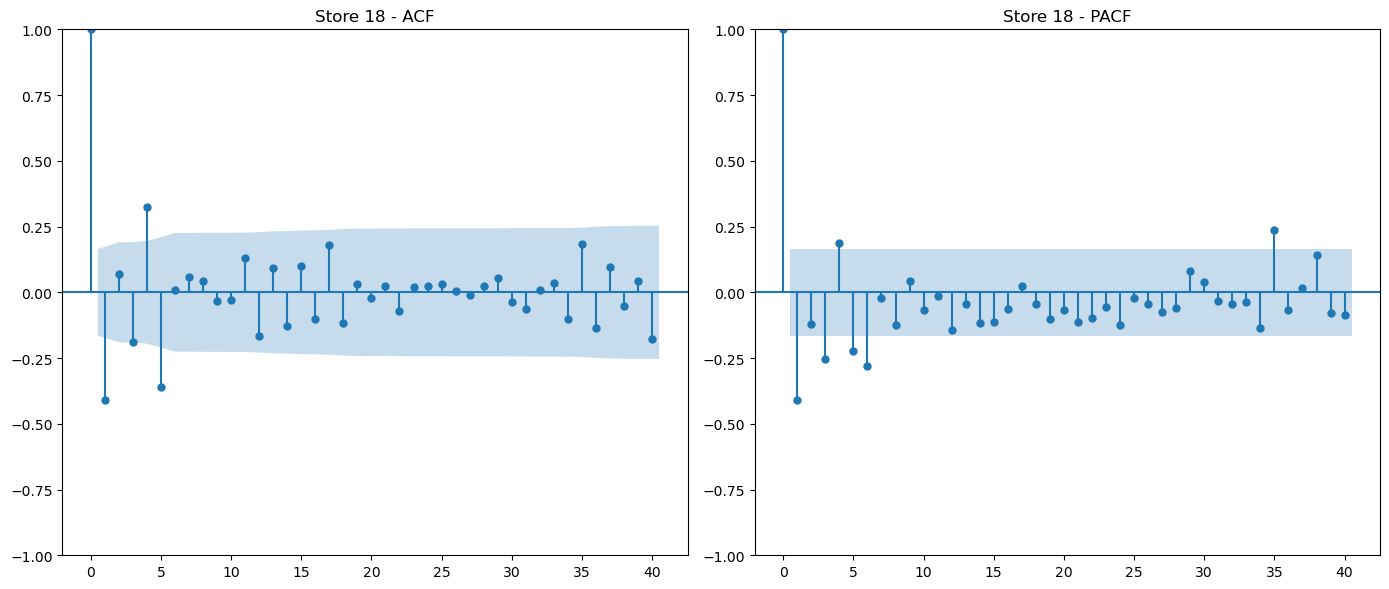

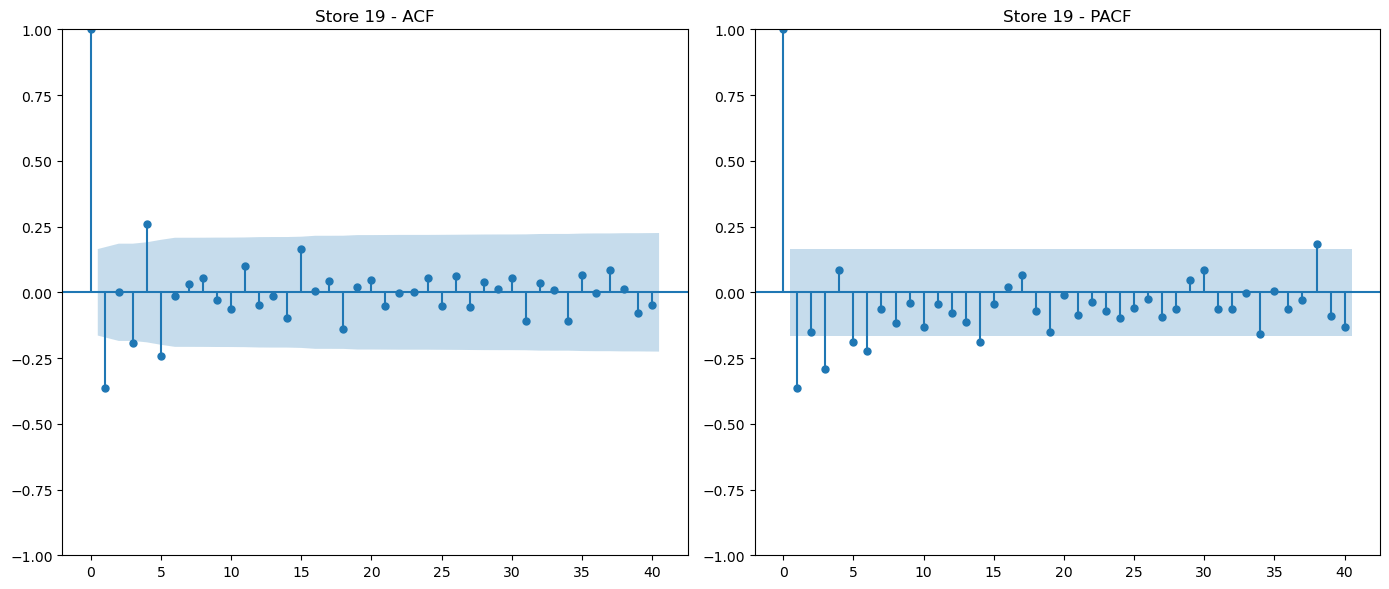

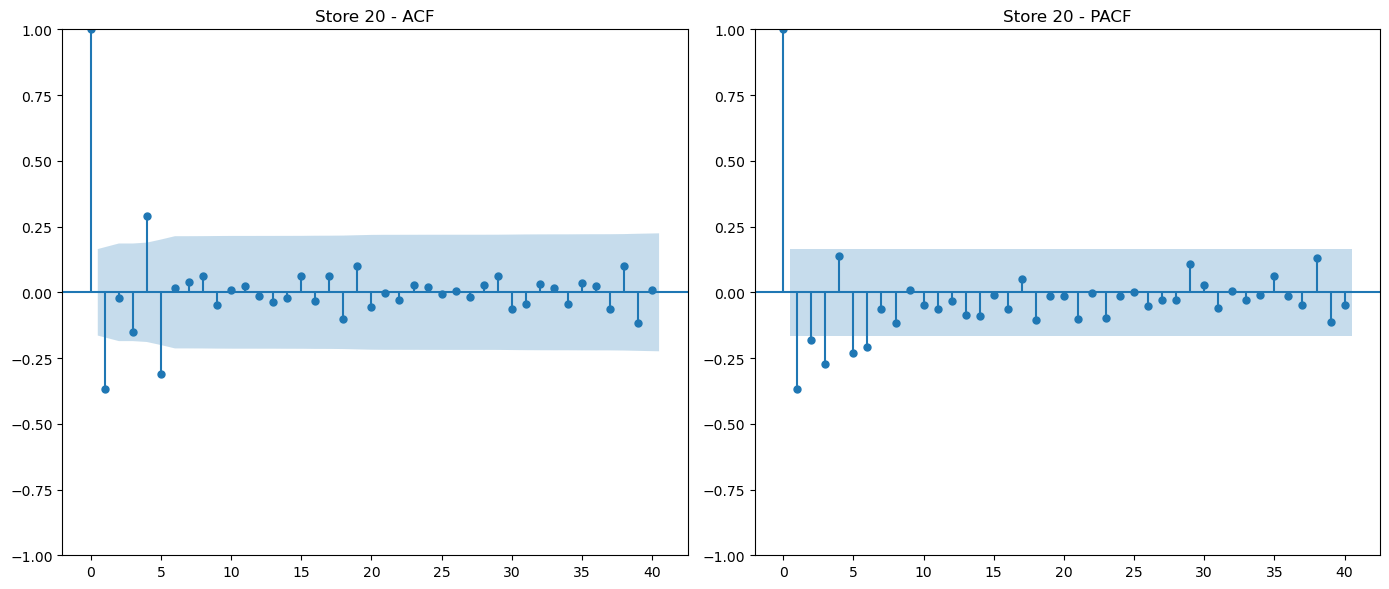

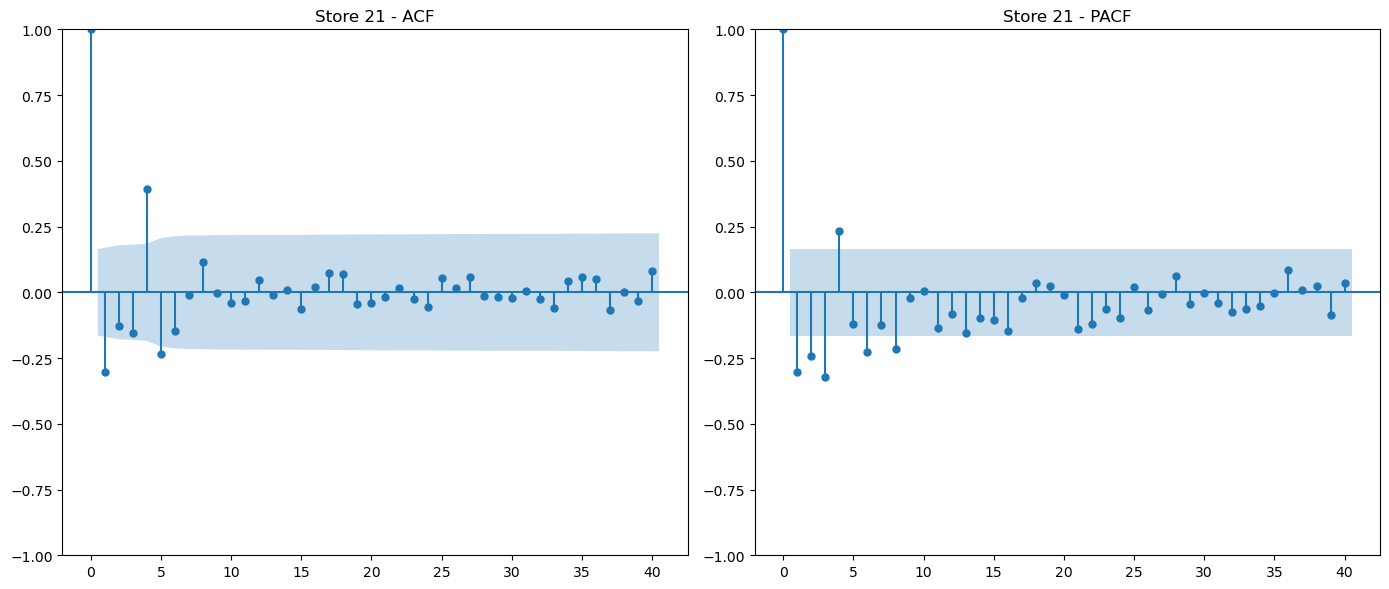

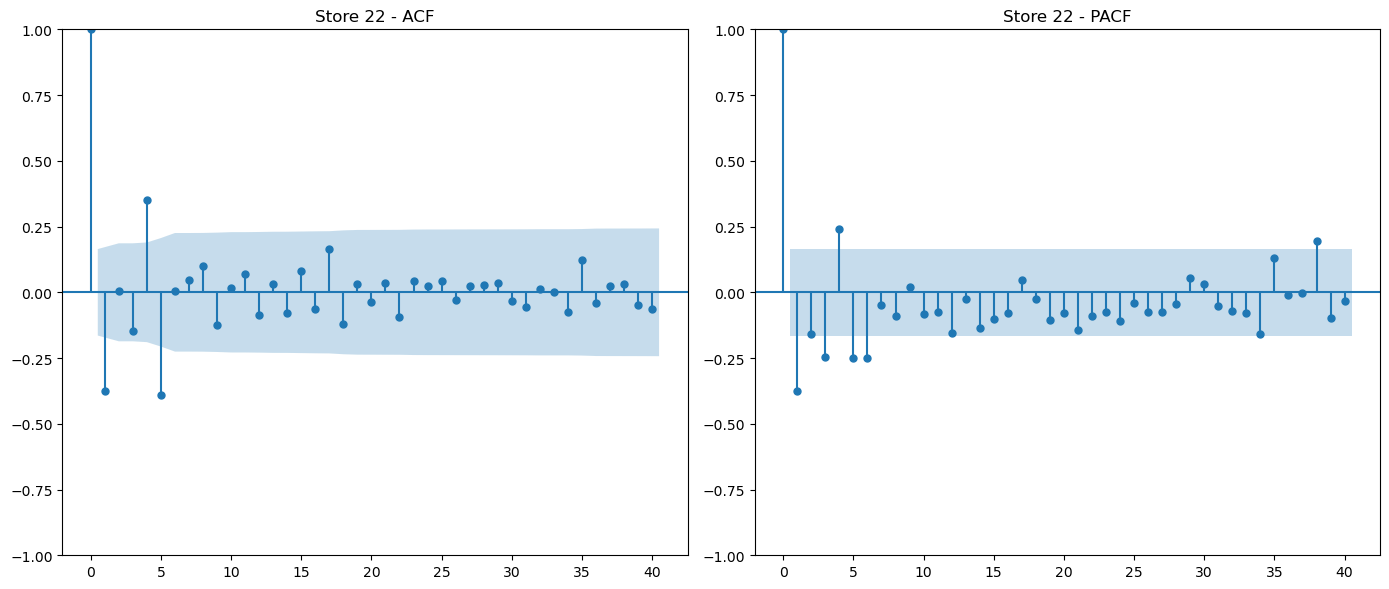

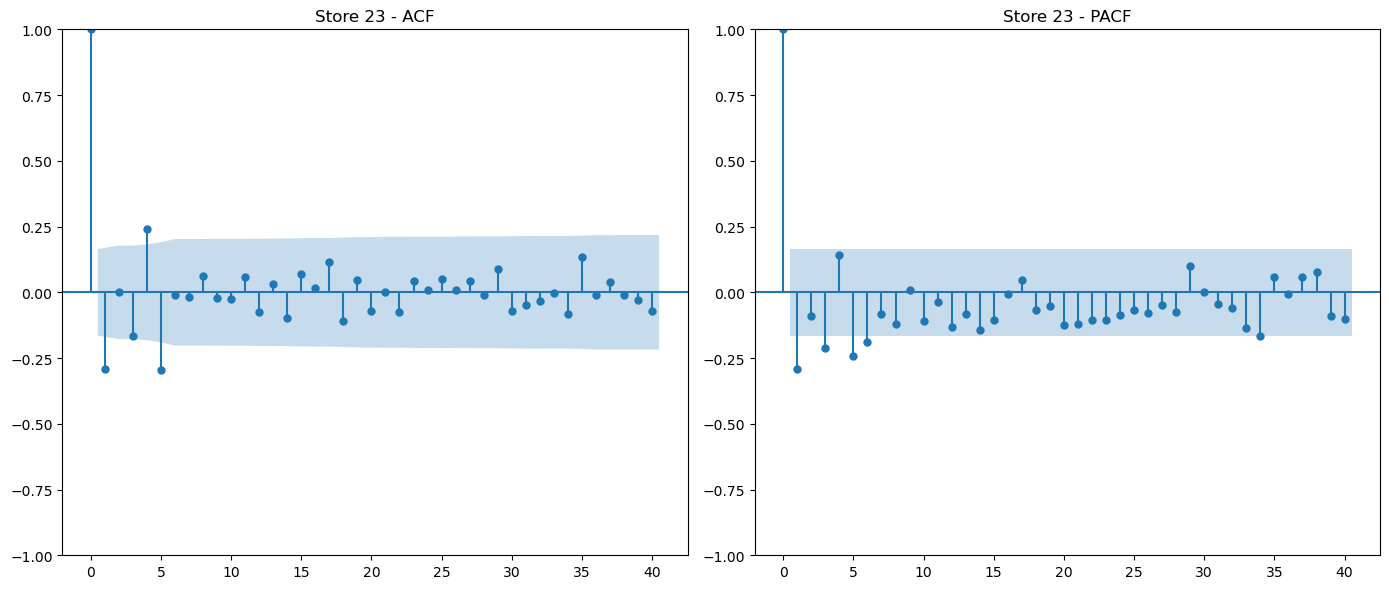

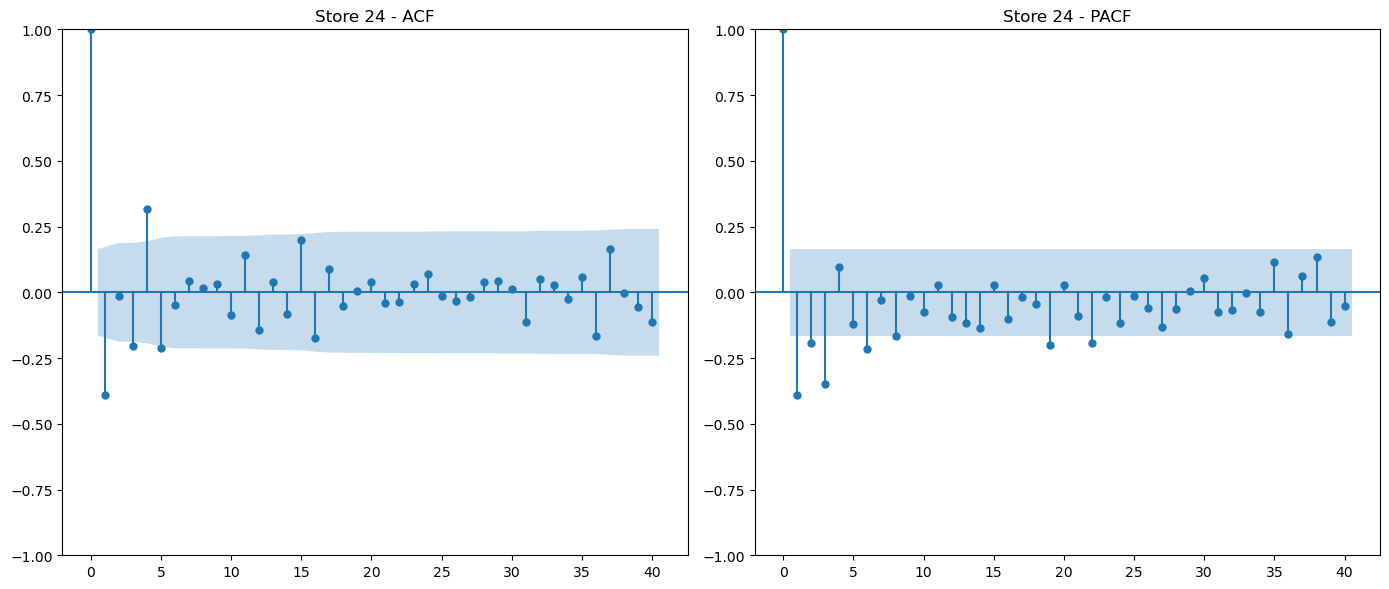

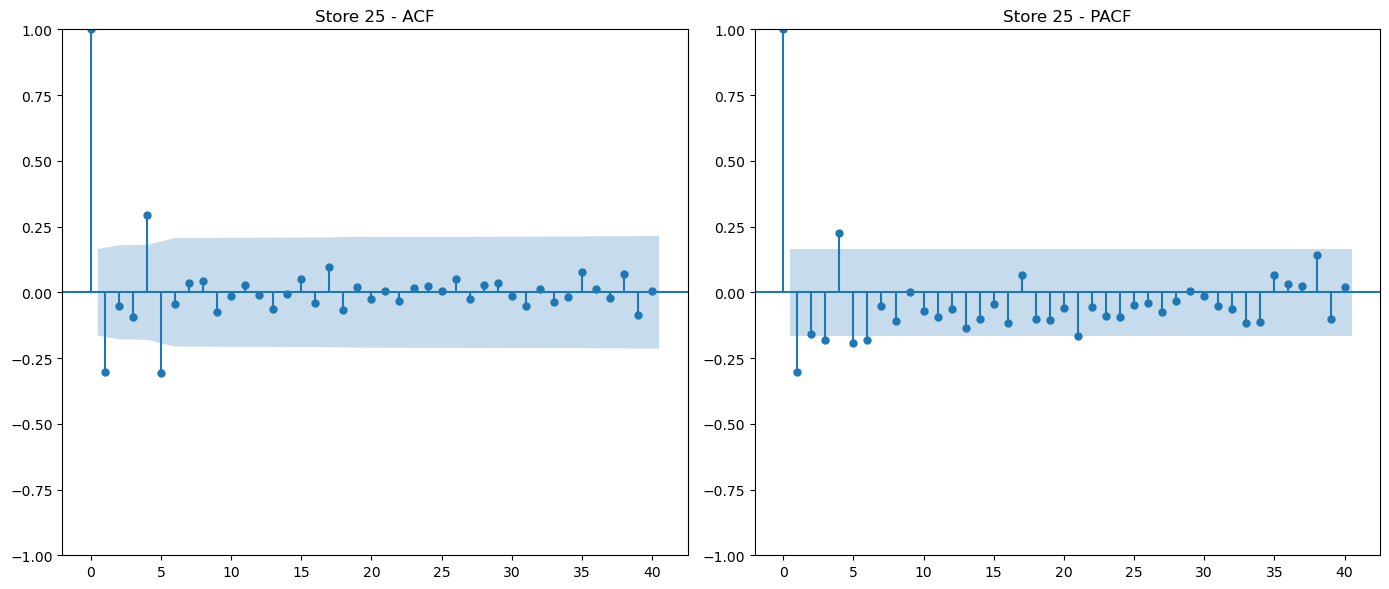

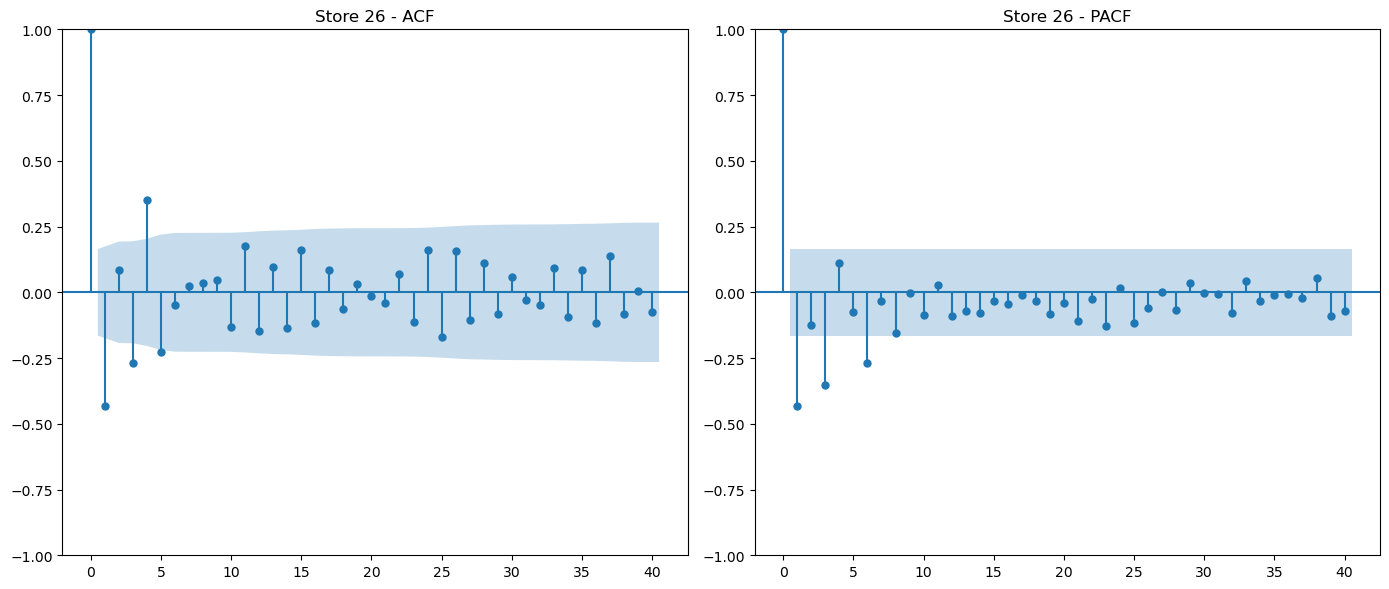

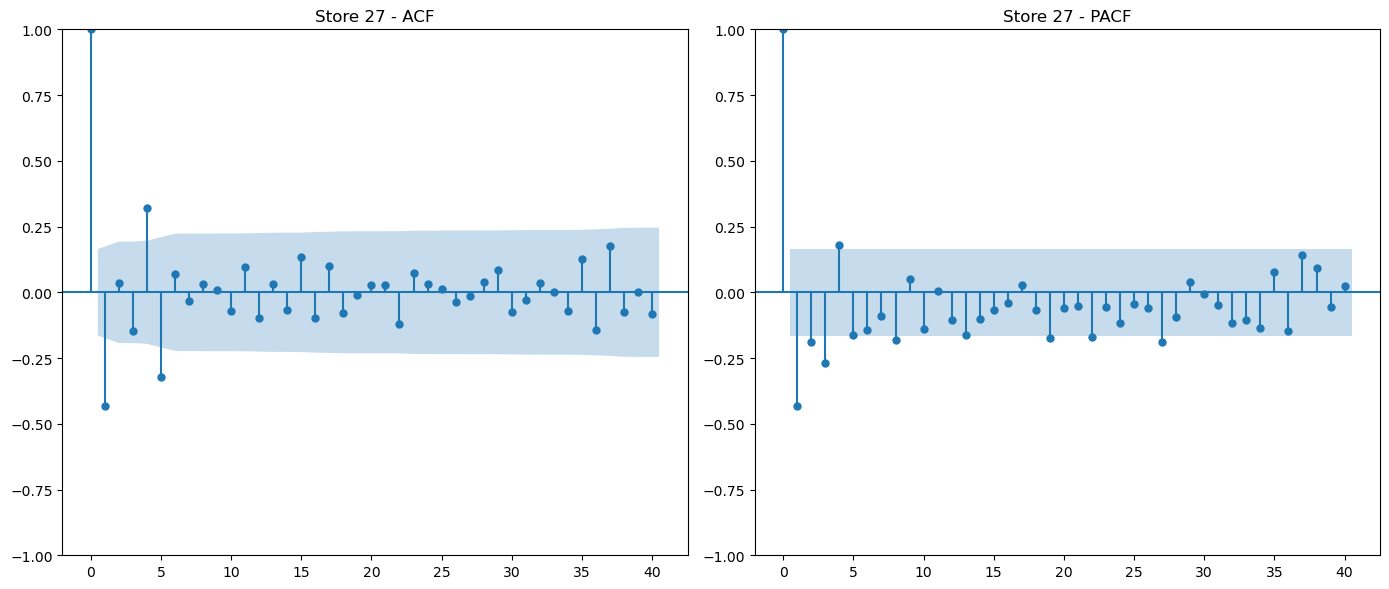

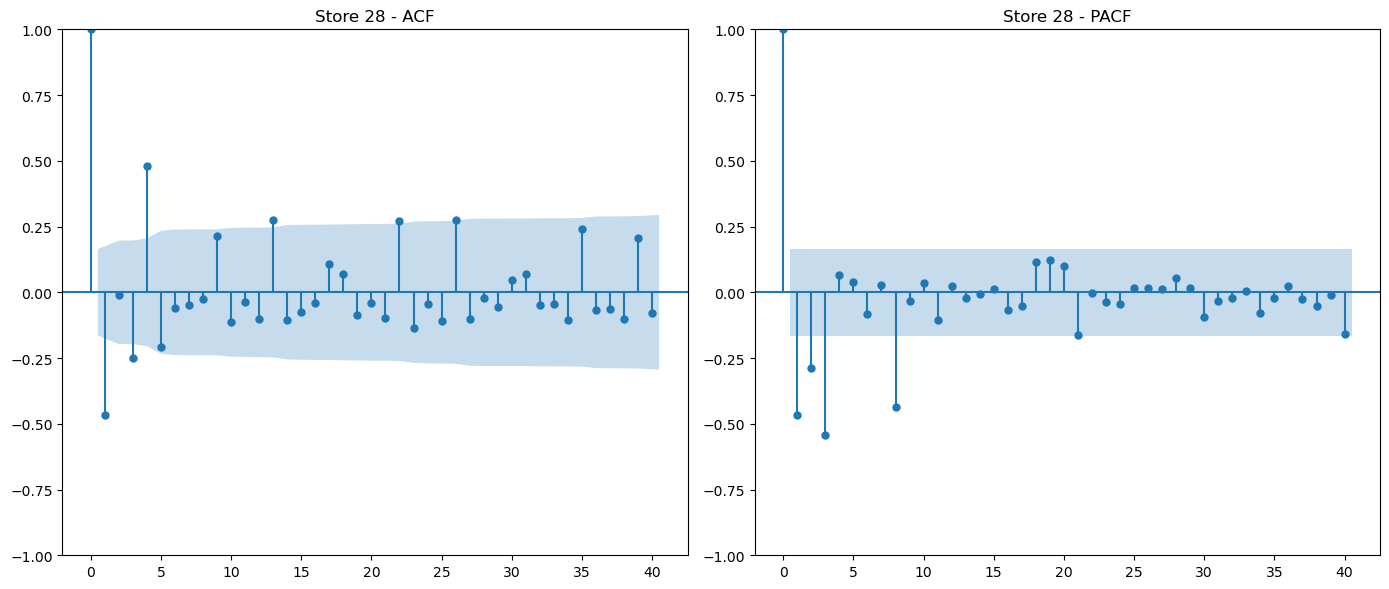

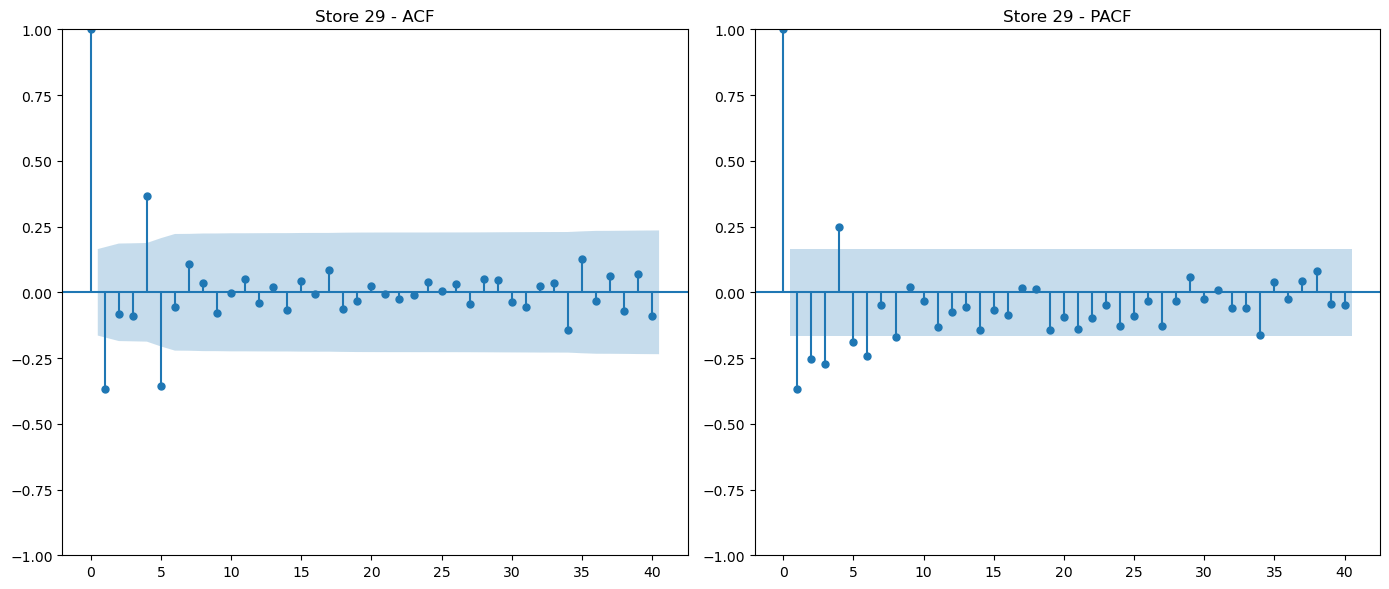

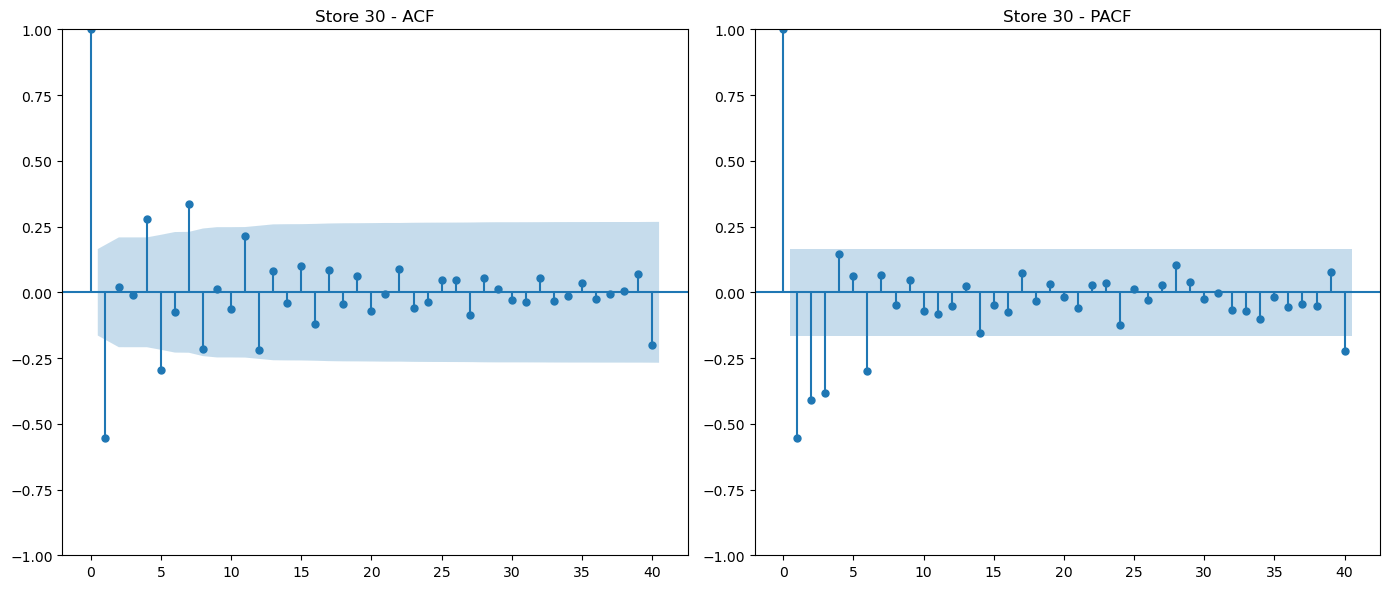

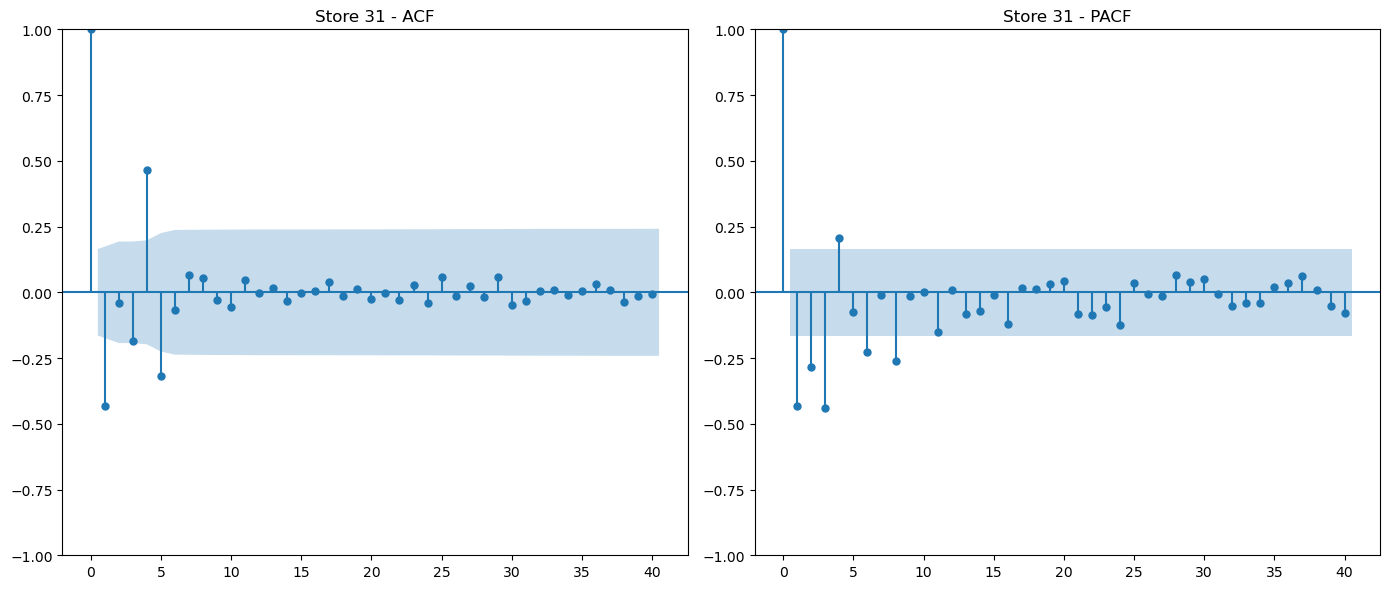

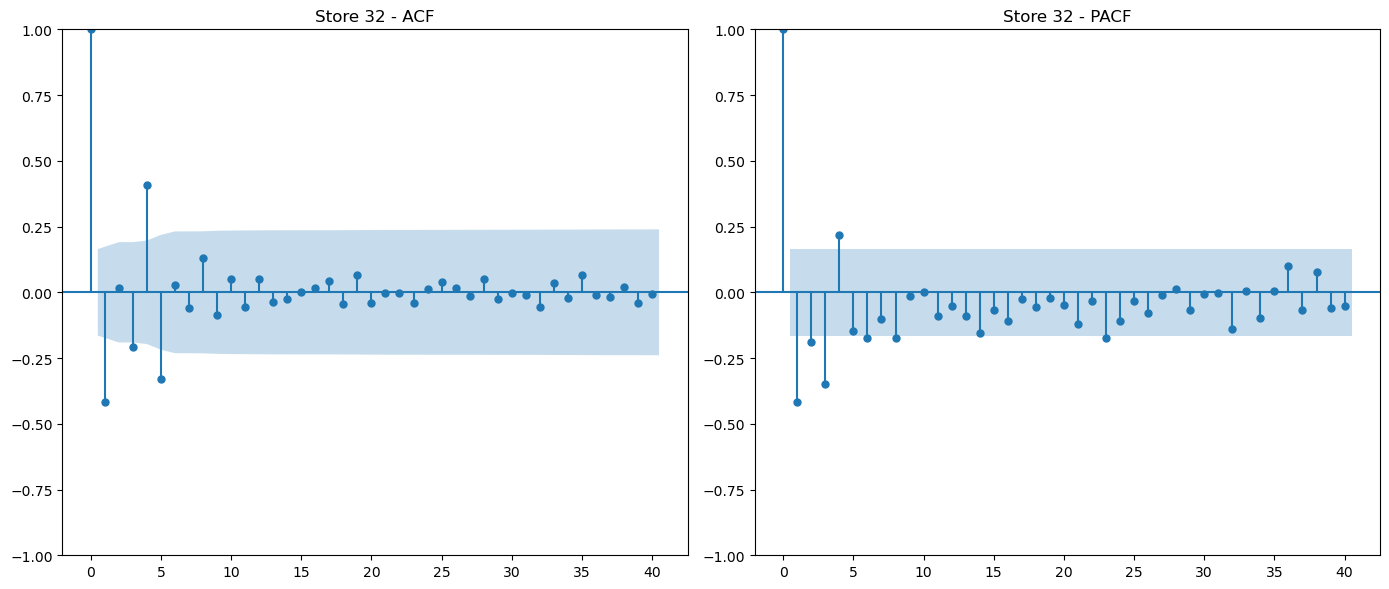

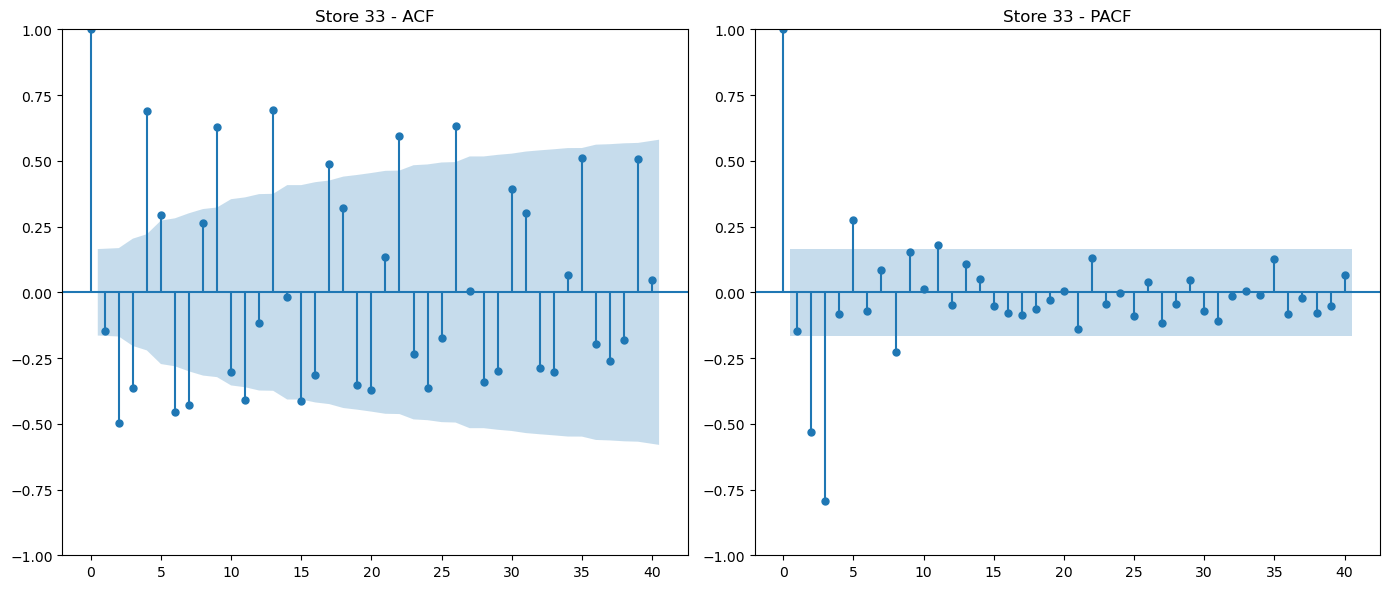

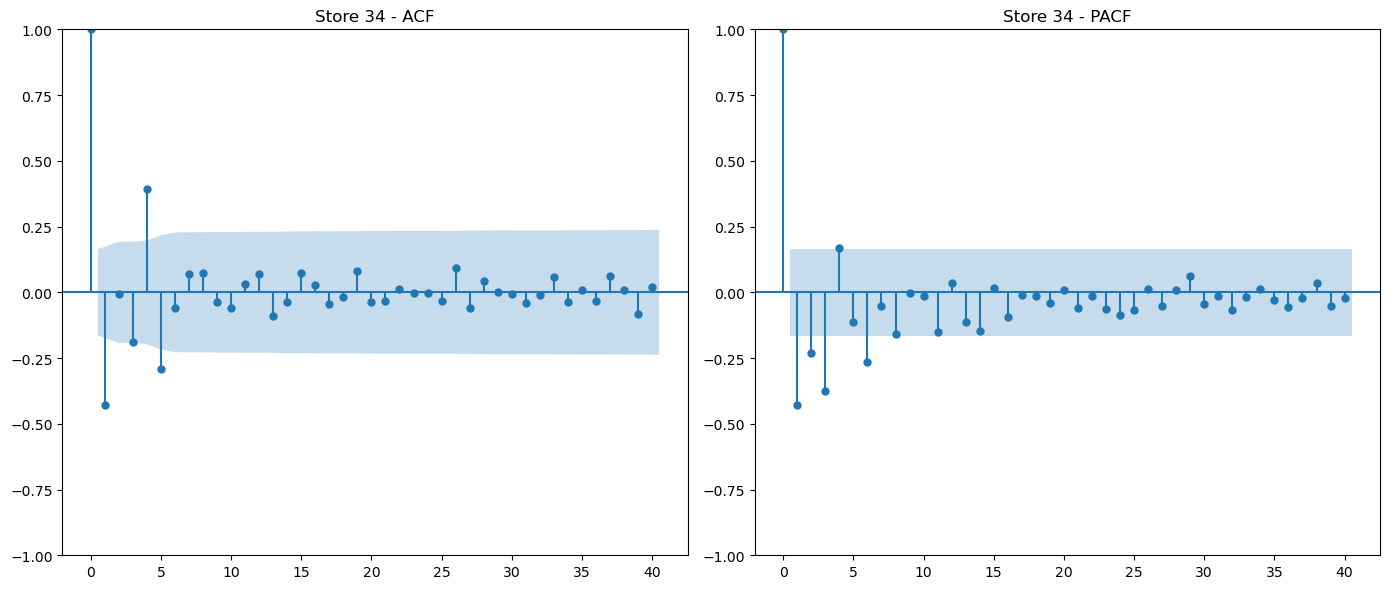

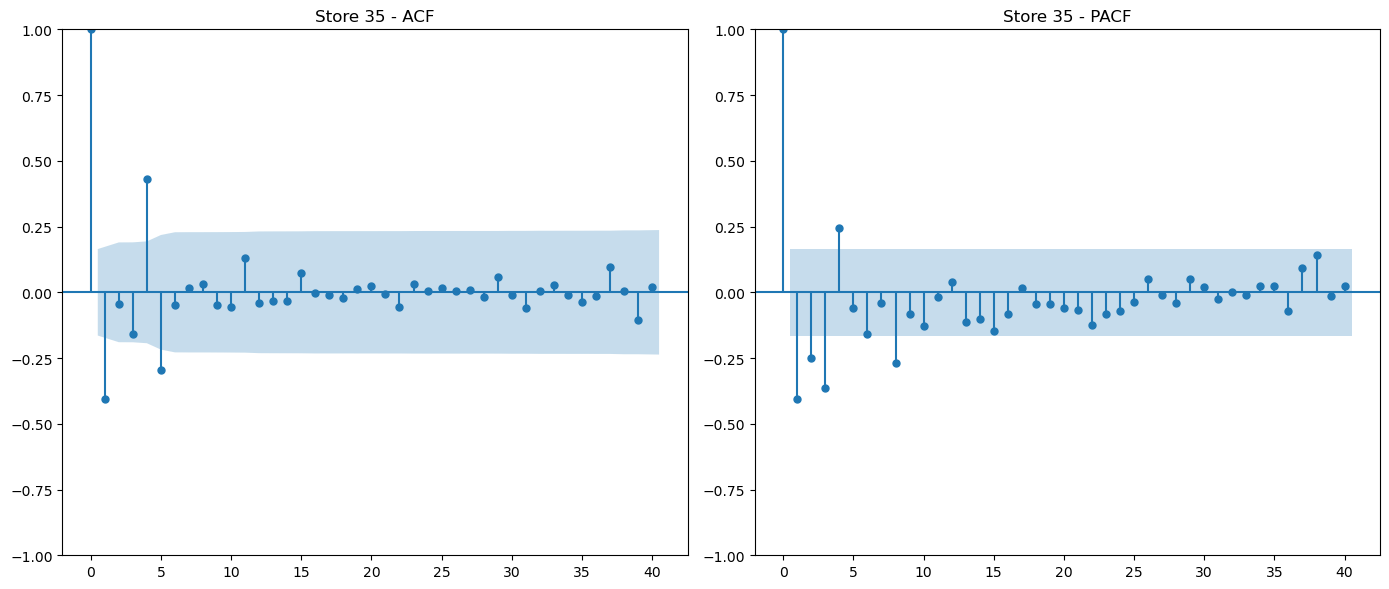

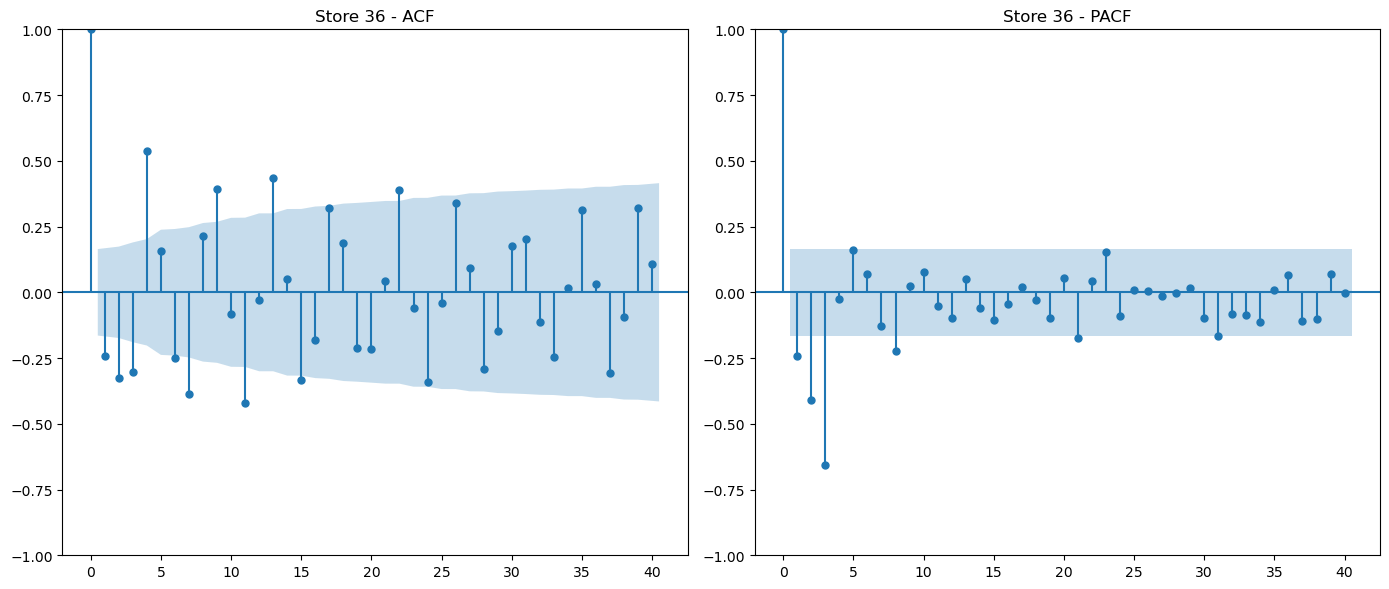

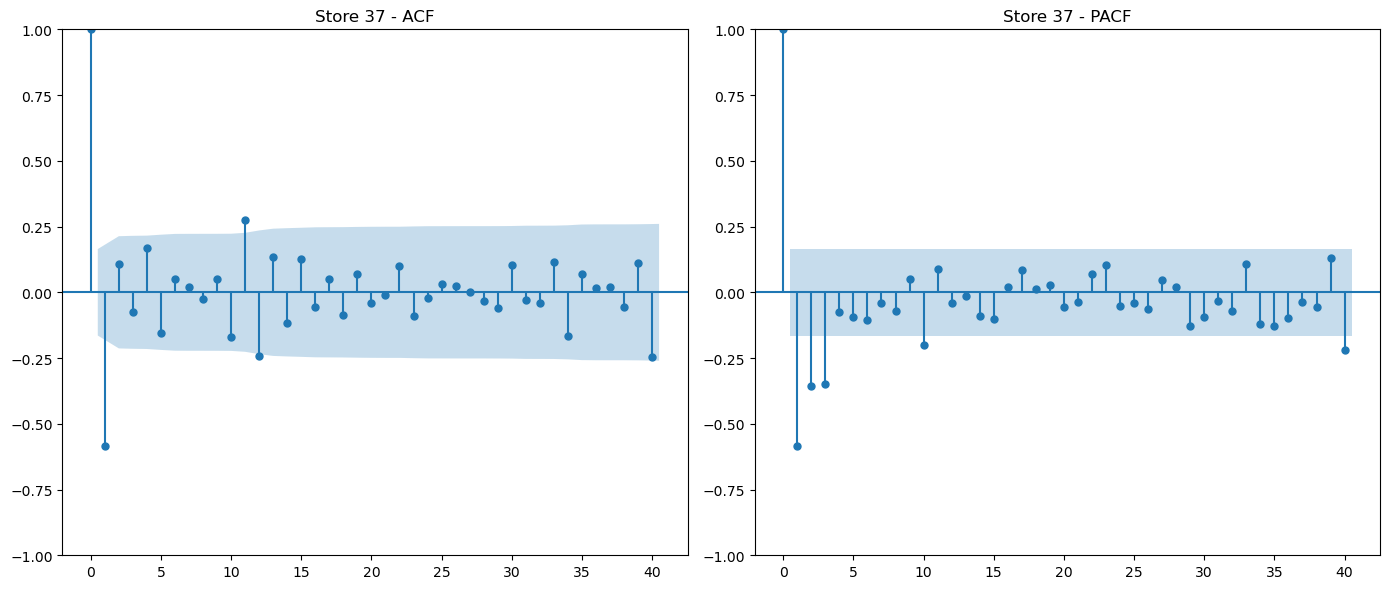

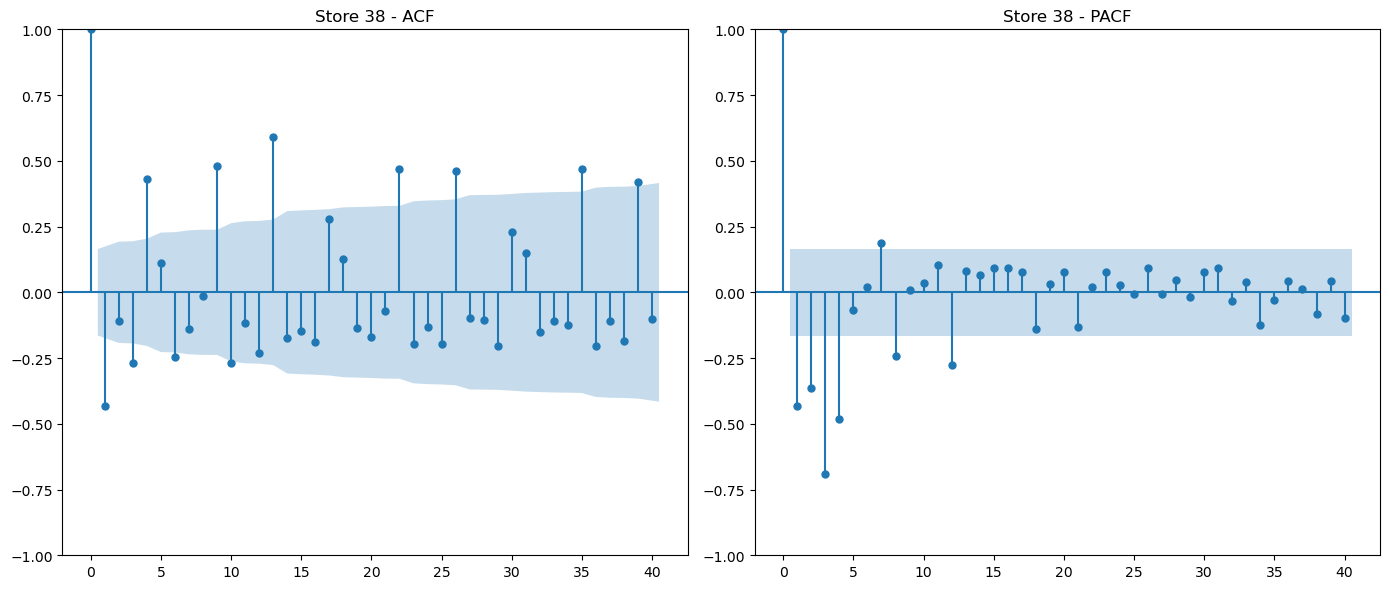

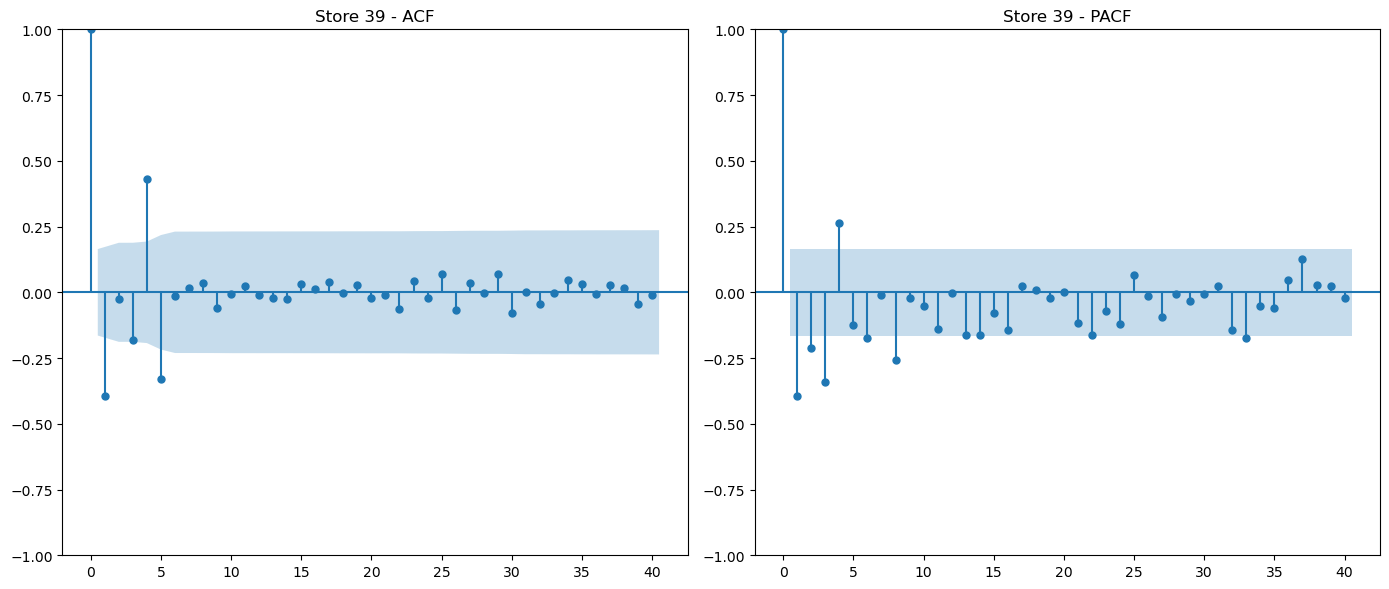

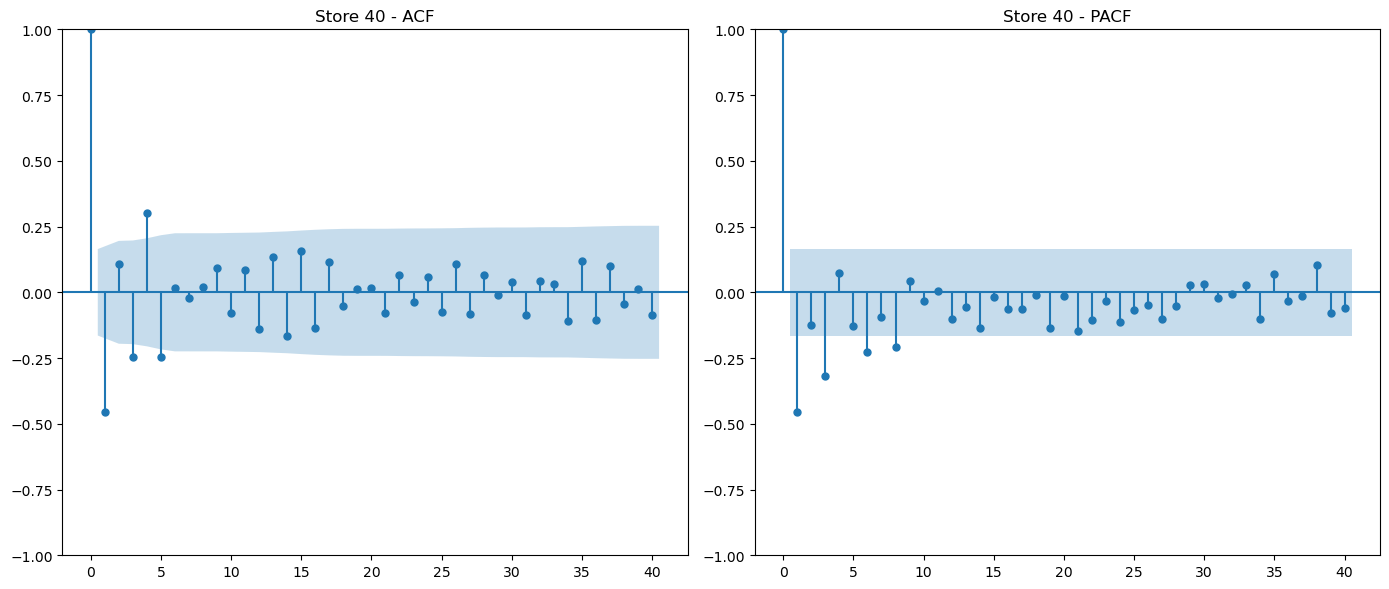

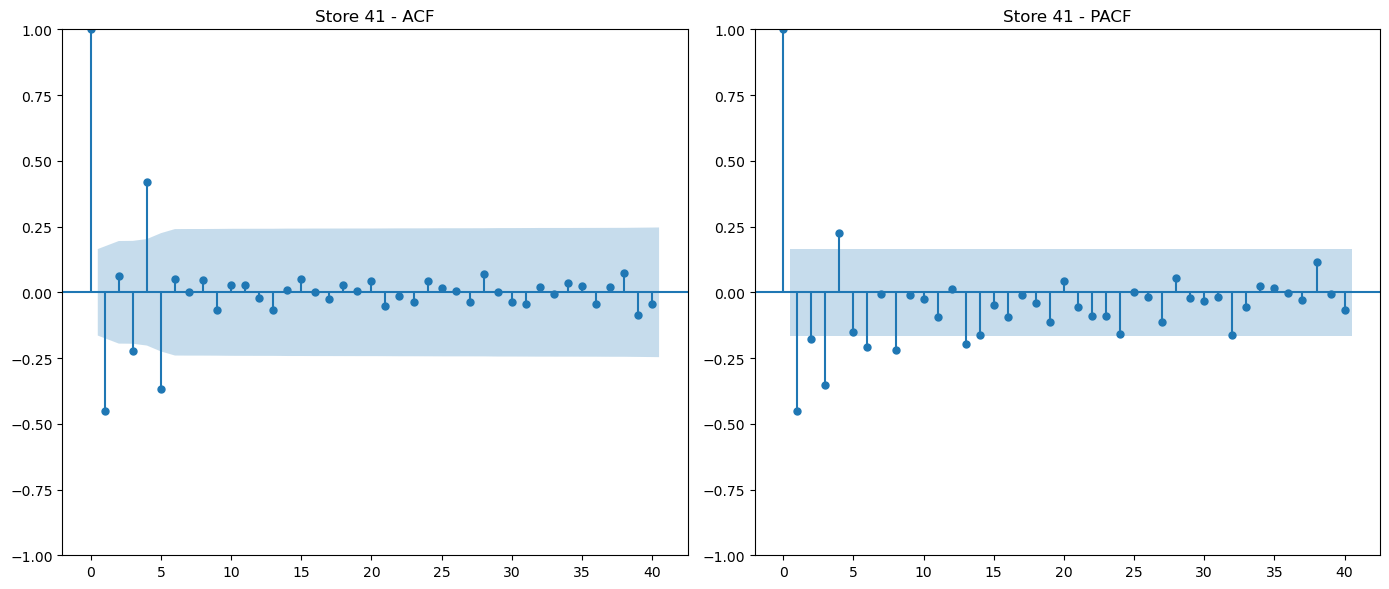

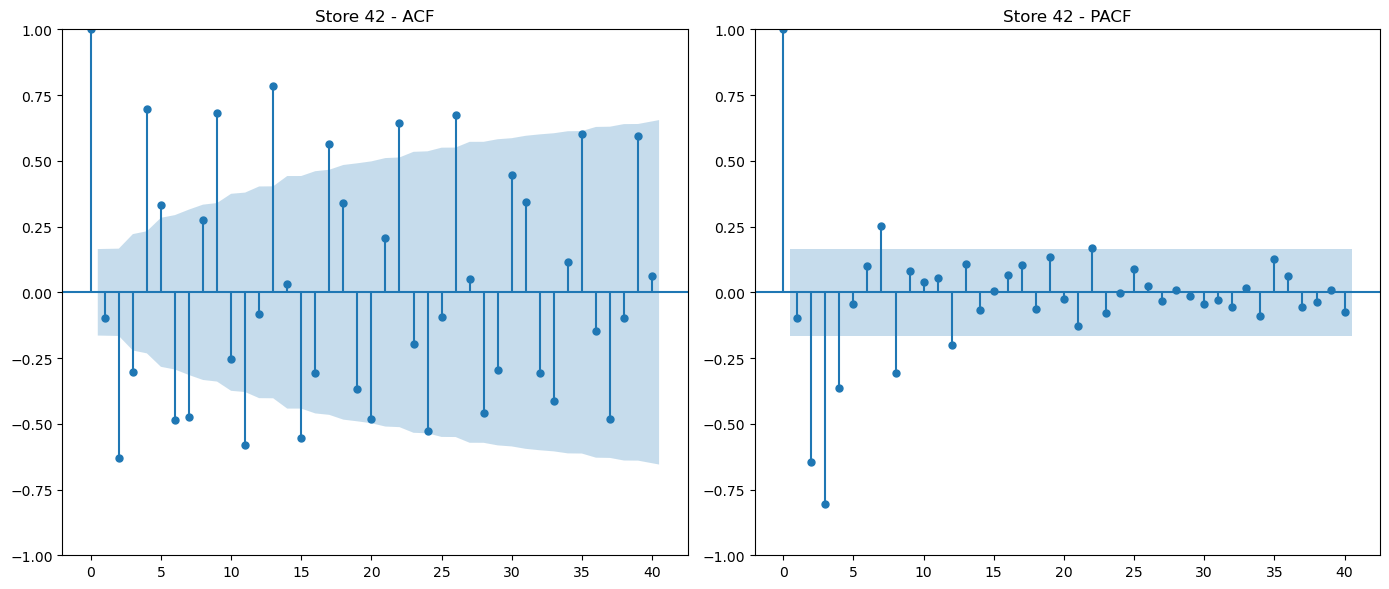

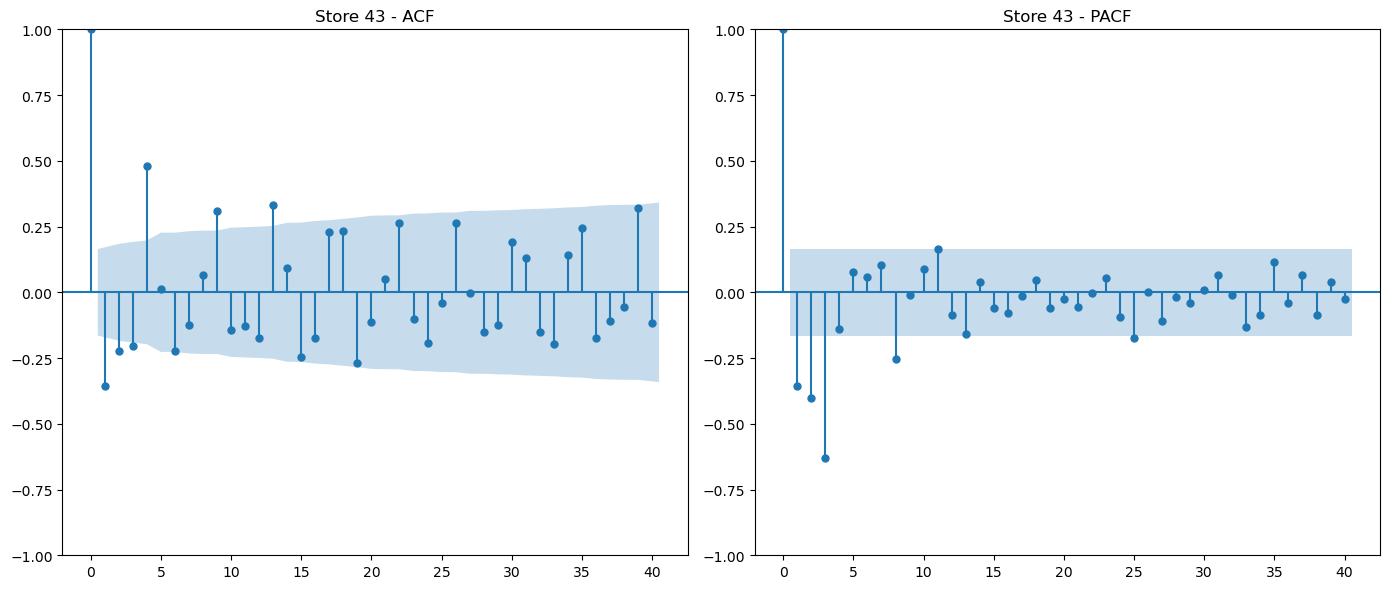

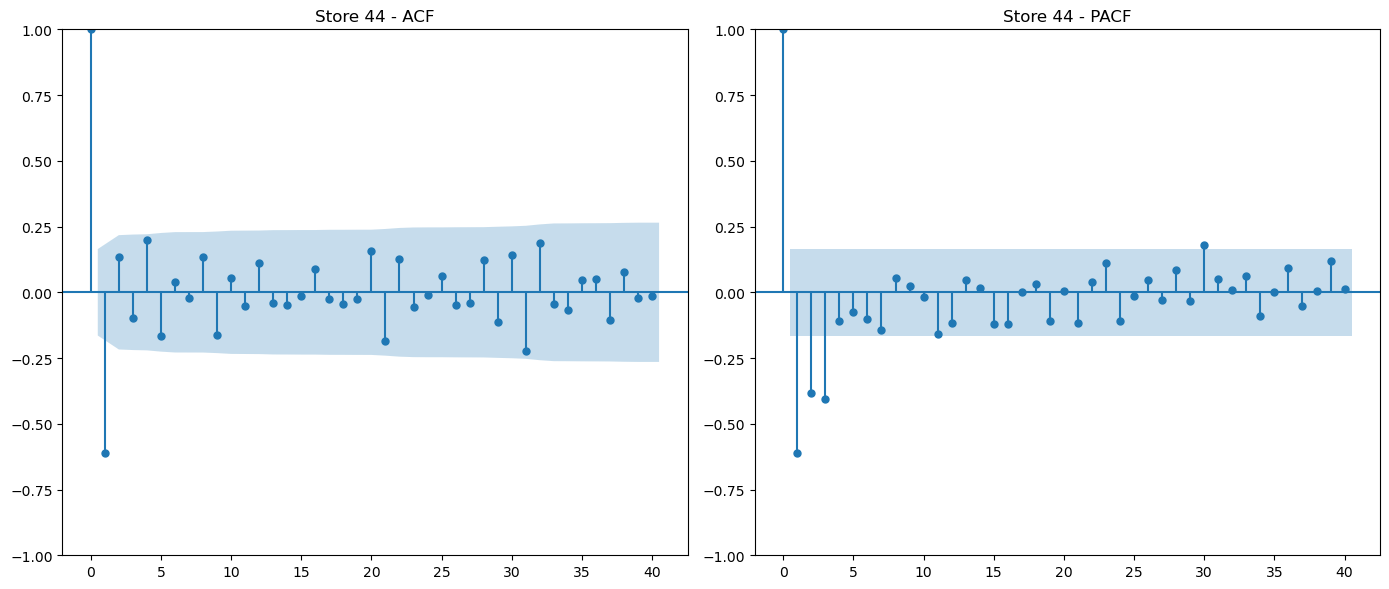

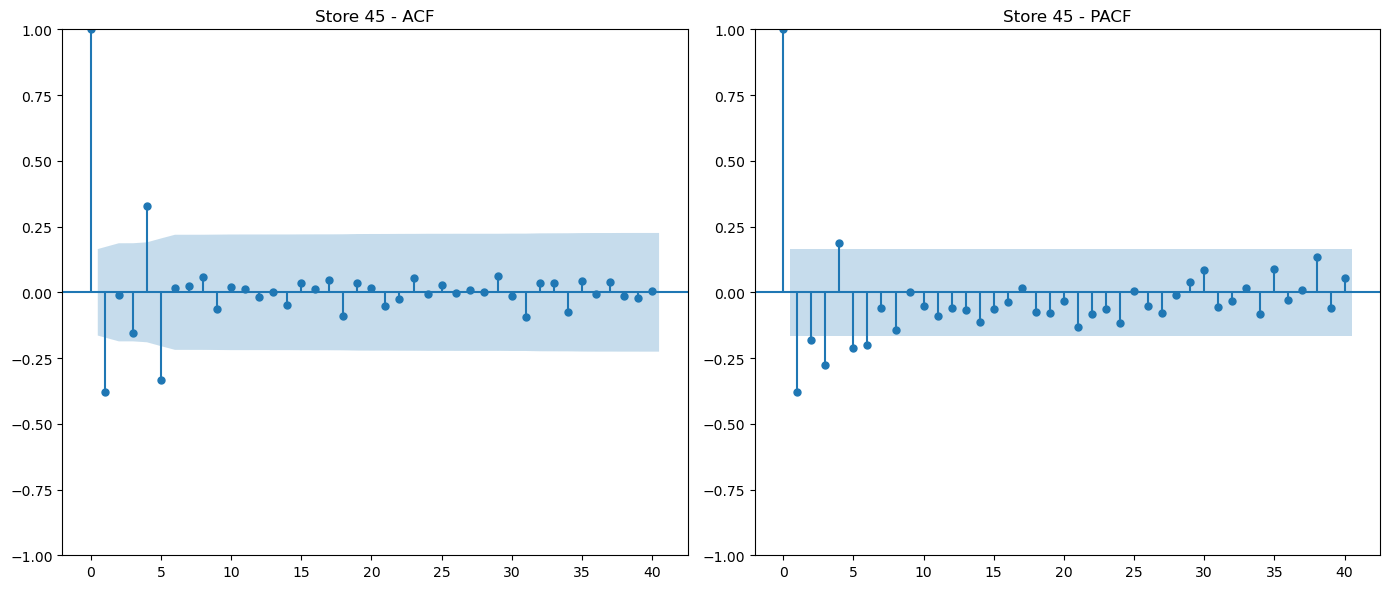

In [84]:
def plot_acf_pacf_all_stores(df, lags=40):
    store_ids = df['Store'].unique()
    
    for store_id in store_ids:
        store_data = df[df['Store'] == store_id].set_index('Date')
        sales = store_data['Weekly_Sales'].dropna()

        # Apply differencing for stationarity
        sales_diff = sales.diff().dropna()
        
        if len(sales_diff) < lags:
            print(f"Skipping Store {store_id} due to insufficient data.")
            continue

        plt.figure(figsize=(14, 6))
        
        # ACF
        plt.subplot(1, 2, 1)
        plot_acf(sales_diff, lags=lags, ax=plt.gca())
        plt.title(f'Store {store_id} - ACF')

        # PACF
        plt.subplot(1, 2, 2)
        plot_pacf(sales_diff, lags=lags, ax=plt.gca(), method='ywm')
        plt.title(f'Store {store_id} - PACF')

        plt.tight_layout()
        plt.show()

# Run the function on your weekly_df
plot_acf_pacf_all_stores(weekly_df, lags=40)

In [85]:
# train_test_split

train_df = sales_diff[:-12]
test_df = sales_diff[-12:]

In [86]:
model = ARIMA(train_df, order=(1,0,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:           Weekly_Sales   No. Observations:                  130
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1434.836
Date:                Wed, 15 Oct 2025   AIC                           2877.672
Time:                        10:12:13   BIC                           2889.142
Sample:                             0   HQIC                          2882.333
                                - 130                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        471.4957    183.316      2.572      0.010     112.202     830.789
ar.L1         -0.2676      0.076     -3.544      0.000      -0.416      -0.120
ma.L1         -0.8634      0.052    -16.664      0.0

In [87]:
forecast_arima = model_fit.forecast(steps=12)
print("arima forecast:",forecast_arima)

arima forecast: 130   -5830.281020
131    2157.780102
132      20.265072
133     592.239977
134     439.185946
135     480.141478
136     469.182239
137     472.114808
138     471.330086
139     471.540069
140     471.483880
141     471.498915
Name: predicted_mean, dtype: float64


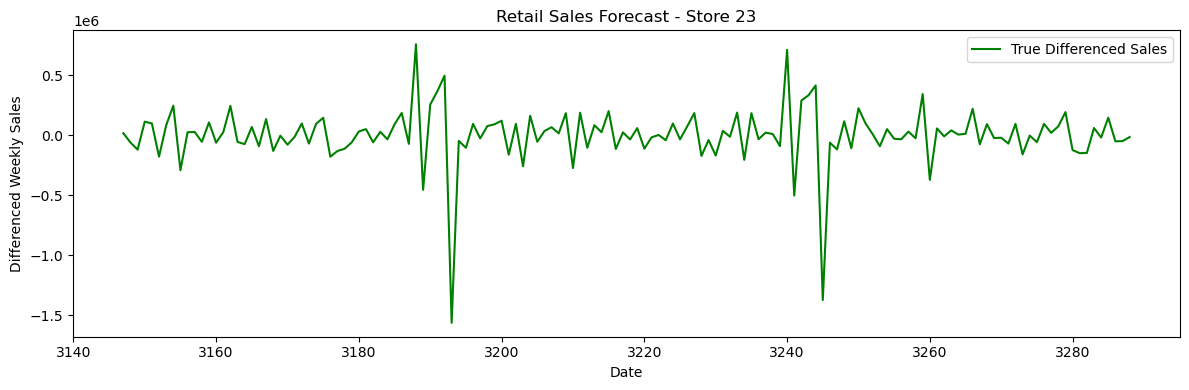

In [88]:
# Define store ID
store_id = 23

# Filter and prepare data for the store
store_data = weekly_df[weekly_df['Store'] == store_id].sort_values('Date')
sales = store_data['Weekly_Sales'].dropna()
sales_diff = sales.diff().dropna()

# Train-test split (assuming last 12 points are test)
test_df = sales_diff.iloc[-12:]

# Create forecast series with test index
prediction_series = pd.Series(forecast_arima, index=test_df.index)

# Plot forecast vs actual
plt.figure(figsize=(12, 4))
plt.plot(sales_diff, label='True Differenced Sales', color='green')
plt.title(f"Retail Sales Forecast - Store {store_id}")
plt.xlabel("Date")
plt.ylabel("Differenced Weekly Sales")
plt.legend()
plt.tight_layout()
plt.show()

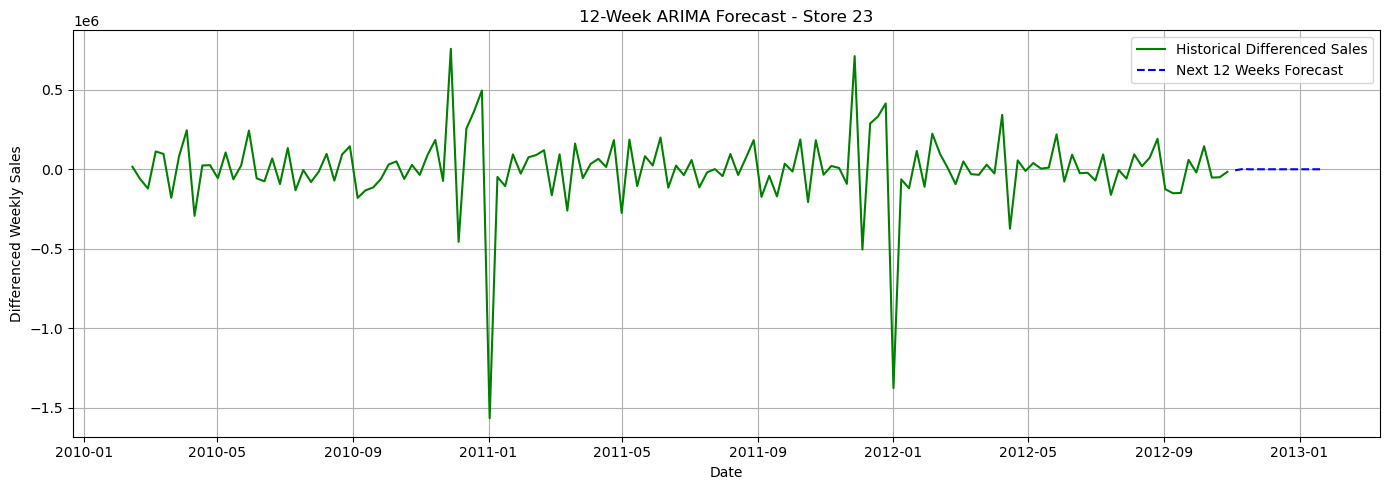

In [89]:
# Define store ID
store_id = 23

# Forecast next 12 weeks (on differenced scale)
future_forecast = model_fit.forecast(steps=12)

# Create future date index
last_known_date = store_data['Date'].max()
future_dates = pd.date_range(start=last_known_date + pd.Timedelta(weeks=1), periods=12, freq='W')

# Create forecast series
future_series = pd.Series(future_forecast.values, index=future_dates)

# Plot historical differenced sales and forecast
plt.figure(figsize=(14, 5))
plt.plot(store_data['Date'][1:], sales_diff, label='Historical Differenced Sales', color='green')
plt.plot(future_series.index, future_series, label='Next 12 Weeks Forecast', color='blue', linestyle='--')
plt.title(f"12-Week ARIMA Forecast - Store {store_id}")
plt.xlabel("Date")
plt.ylabel("Differenced Weekly Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [90]:
rmse = np.sqrt(mean_squared_error(test_df, forecast_arima))
mae = mean_absolute_error(test_df, forecast_arima)
r2 = r2_score(test_df, forecast_arima)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.4f}")

RMSE: 105530.63
MAE: 88042.15
R² Score: -0.0053


In [91]:
#SARIMA

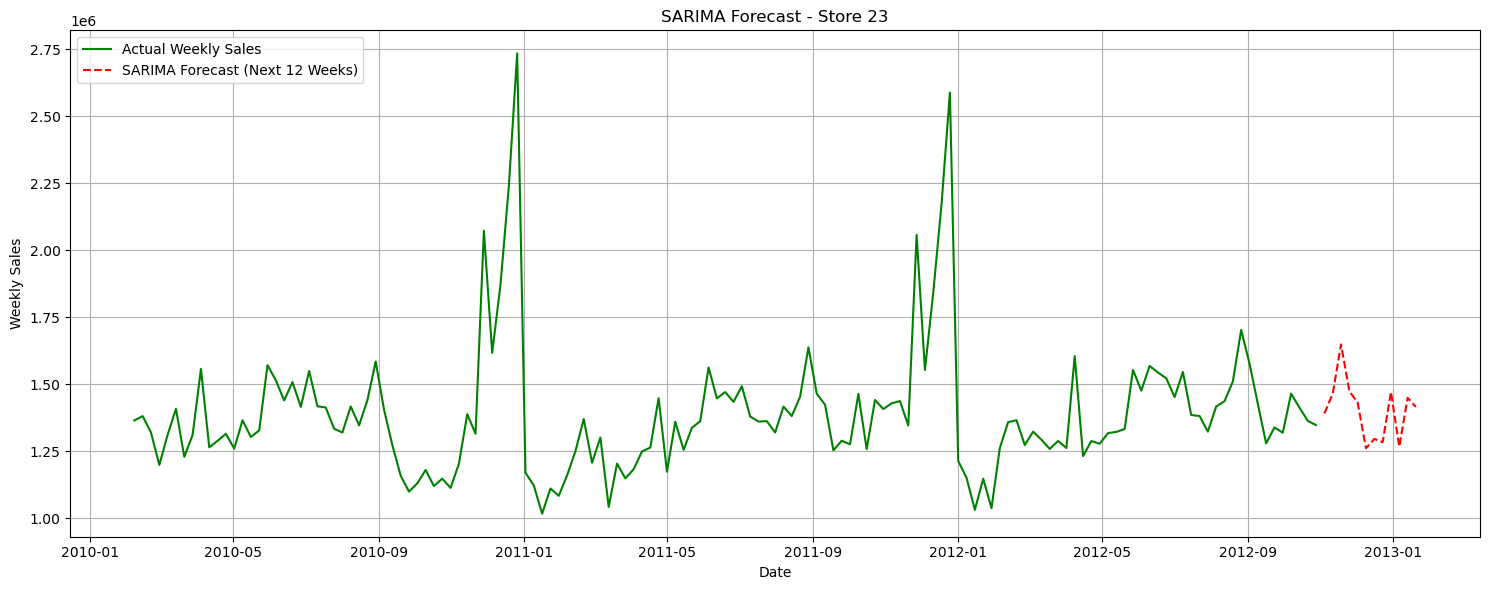

In [93]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Filter store-specific data
store_id = 23
store_data = weekly_df[weekly_df['Store'] == store_id].sort_values('Date')
store_data['Date'] = pd.to_datetime(store_data['Date'])  # Ensure datetime
sales = store_data['Weekly_Sales'].dropna()
sales.index = store_data['Date']  # Set datetime index

# Train SARIMA model
forecast_horizon = 12
train = sales.iloc[:-forecast_horizon]
test = sales.iloc[-forecast_horizon:]
model = SARIMAX(train, order=(2, 0, 2), seasonal_order=(1, 1, 1, 52))
model_fit = model.fit(disp=False)

# Forecast next 12 weeks
future_forecast = model_fit.forecast(steps=forecast_horizon)

# Create future date index based on last known store-specific date
last_known_date = sales.index[-1]
future_dates = pd.date_range(start=last_known_date + pd.Timedelta(weeks=1), periods=forecast_horizon, freq='W')

# Create forecast series
future_forecast_series = pd.Series(future_forecast.values, index=future_dates)

# Plot actual sales and forecast
plt.figure(figsize=(15,6))
plt.plot(sales, label='Actual Weekly Sales', color='green')
plt.plot(future_forecast_series, label='SARIMA Forecast (Next 12 Weeks)', color='red', linestyle='--')
plt.title(f"SARIMA Forecast - Store {store_id}")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend(loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

In [94]:
rmse = np.sqrt(mean_squared_error(test, future_forecast))
mae = mean_absolute_error(test, future_forecast)
r2 = r2_score(test, future_forecast)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.4f}")

RMSE: 67545.36
MAE: 54697.58
R² Score: 0.6546


# 5. Evaluation

In [95]:
# ARIMA metrics
arima_rmse = 105530.63
arima_mae = 88042.15
arima_r2 = -0.0053

# SARIMA metrics
sarima_rmse = 67545.36
sarima_mae = 54697.58
sarima_r2 = 0.6546

# Create comparison table
comparison_df = pd.DataFrame({
    'Model': ['ARIMA', 'SARIMA'],
    'RMSE': [arima_rmse, sarima_rmse],
    'MAE': [arima_mae, sarima_mae],
    'R² Score': [arima_r2, sarima_r2]
})

# Display neatly
print(comparison_df)

    Model       RMSE       MAE  R² Score
0   ARIMA  105530.63  88042.15   -0.0053
1  SARIMA   67545.36  54697.58    0.6546


# 6. Forecast Visualization

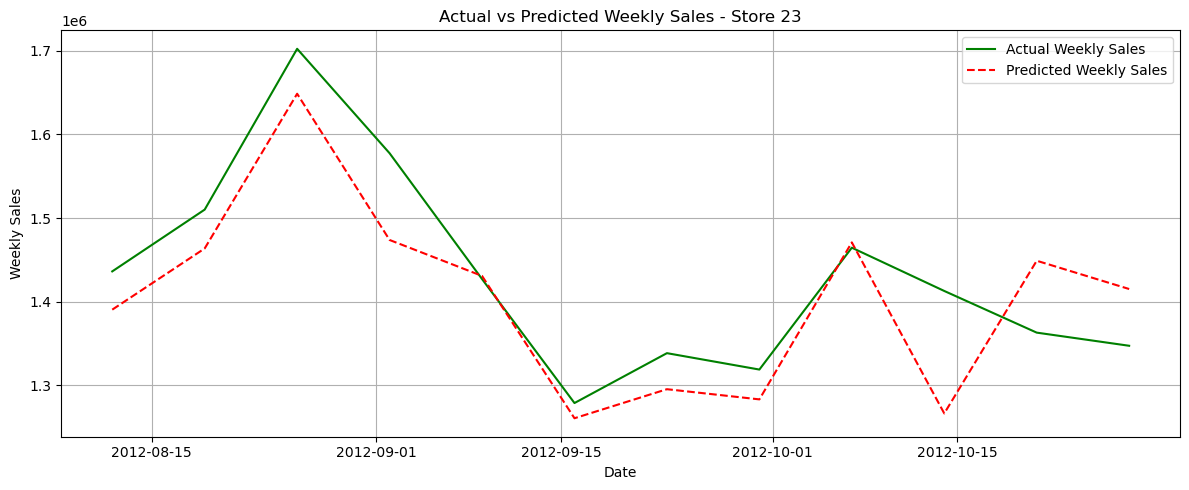

In [96]:
#Actual vs Predicted Weekly Sales (line chart).
plt.figure(figsize=(12,5))
plt.plot(test.index, test, label='Actual Weekly Sales', color='green')
plt.plot(test.index, future_forecast, label='Predicted Weekly Sales', color='red', linestyle='--')

plt.title(f"Actual vs Predicted Weekly Sales - Store {store_id}")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

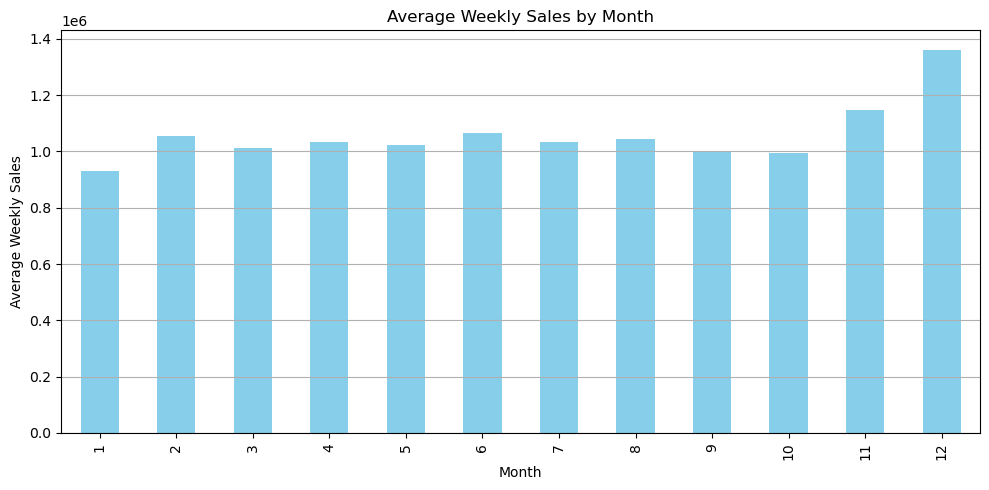

In [97]:
#Monthly Seasonality Plot
# Extract month from date
weekly_df['Month'] = pd.to_datetime(weekly_df['Date']).dt.month

# Group by month and average sales
monthly_trend = weekly_df.groupby('Month')['Weekly_Sales'].mean()

# Plot
plt.figure(figsize=(10,5))
monthly_trend.plot(kind='bar', color='skyblue')
plt.title("Average Weekly Sales by Month")
plt.xlabel("Month")
plt.ylabel("Average Weekly Sales")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

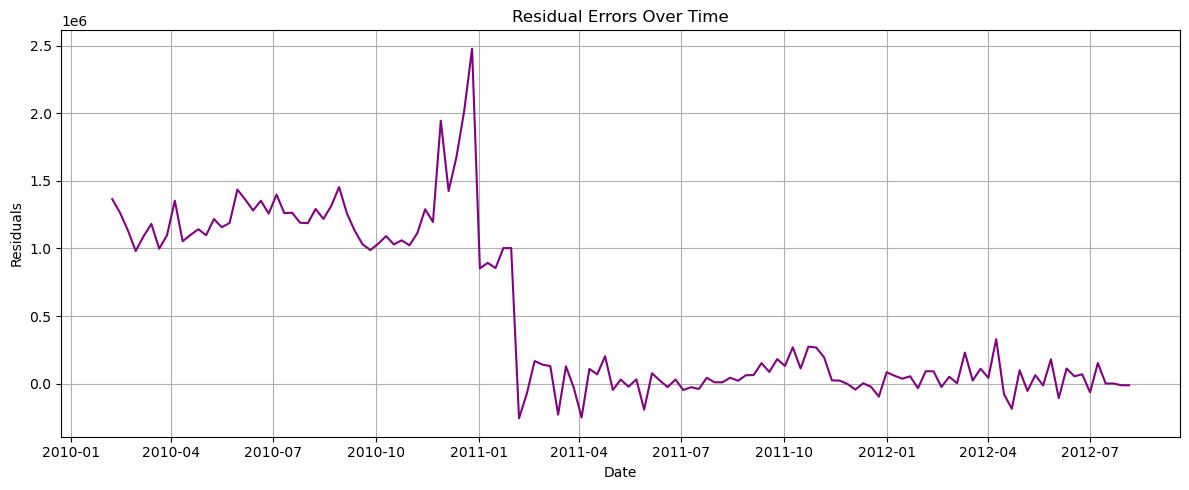

In [98]:
#Residual Error Plot
# Assuming residuals from your model
residuals = model_fit.resid 

# Plot residuals over time
plt.figure(figsize=(12,5))
plt.plot(residuals, color='purple')
plt.title("Residual Errors Over Time")
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.grid(True)
plt.tight_layout()
plt.show()

In [99]:
import pickle

In [100]:
# Save the model
with open('model.pkl', 'wb') as file:
    pickle.dump(model_fit, file)

print("Model saved successfully as model.pkl")

Model saved successfully as model.pkl


In [101]:
import os
print(os.listdir())  

['.anaconda', '.conda', '.condarc', '.continuum', '.idea', '.idlerc', '.ipynb_checkpoints', '.ipython', '.jupyter', '.kivy', '.matplotlib', '.node_repl_history', '.vscode', '.wdc', 'ADABoost.ipynb', 'AppData', 'Application Data', 'assignment1.ipynb', 'calculator.py', 'Contacts', 'Cookies', 'csvdemo.py', 'csvdemo2.py', 'cyberbullying.ipynb', 'cyberbullying.py', 'd1.py', 'data visualization_apr4.ipynb', 'data.txt', 'datascience.txt', 'data_cleaning.ipynb', 'Desktop', 'Documents', 'Downloads', 'example.csv', 'feb3.ipynb', 'firstdemo.py', 'flaskweb', 'Gradient Boosting.ipynb', 'Hiring_ML.ipynb', 'K means project.ipynb', 'Links', 'Local Settings', 'Machine_Learning(Supervised).ipynb', 'Machine_Learning(Unsupervised).ipynb', 'Mall Customer Segmentation dataset.ipynb', 'ML(Consumo_cerveja_assign1).ipynb', 'model.pkl', 'Music', 'My Documents', 'NetHood', 'Normalisation_Preprocessing_using_scikitlearn.ipynb', 'notes.py', 'NTUSER.DAT', 'ntuser.dat.LOG1', 'ntuser.dat.LOG2', 'NTUSER.DAT{7d8a799f-d

In [102]:
import pickle

with open('model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

print(" Model loaded successfully!")

 Model loaded successfully!


In [103]:
forecast = loaded_model.forecast(steps=12)
print(forecast)

2012-08-12    1.390604e+06
2012-08-19    1.463723e+06
2012-08-26    1.648530e+06
2012-09-02    1.473841e+06
2012-09-09    1.430922e+06
2012-09-16    1.260866e+06
2012-09-23    1.295568e+06
2012-09-30    1.283410e+06
2012-10-07    1.470952e+06
2012-10-14    1.266624e+06
2012-10-21    1.449034e+06
2012-10-28    1.415257e+06
Freq: W-SUN, Name: predicted_mean, dtype: float64
